In [2]:
import datetime
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datlib.FRED import *
from datlib.plots import *
import pandas_datareader.data as web

%matplotlib inline

# Import Statsmodels

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [3]:
#FRED.py
#. . . 
def bil_to_mil(series):
    return series* 10**3
# . . .
#fedProject.py
# . . .
data_codes  = {# Assets
               "Balance Sheet: Total Assets ($ Mil)": "WALCL",
               "Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)": "WSRLL",
               "Balance Sheet: Securities Held Outright ($ Mil)": "WSHOSHO",
               ### breakdown of securities holdings ###
               "Balance Sheet: U.S. Treasuries Held Outright ($ Mil)":"WSHOTSL",
               "Balance Sheet: Federal Agency Debt Securities ($ Mil)" : "WSHOFADSL",
               "Balance Sheet: Mortgage-Backed Securities ($ Mil)": "WSHOMCB",
               # other forms of lending
               "Balance Sheet: Repos ($ Mil)": "WORAL",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)" : "SWPT",
               "Balance Sheet: Direct Lending ($ Mil)" : "WLCFLL",
               # unamortized value of securities held (due to changes in interest rates)
               "Balance Sheet: Unamortized Security Premiums ($ Mil)": "WUPSHO",
               # Liabilities
               "Balance Sheet: Total Liabilities ($ Mil)" : "WLTLECL",
               "Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)" : "WLFN",
               "Balance Sheet: Reverse Repos ($ Mil)": "WLRRAL",
               ### Major share of deposits 
               "Balance Sheet: Deposits from Dep. Institutions ($ Mil)":"WLODLL",
               "Balance Sheet: U.S. Treasury General Account ($ Mil)": "WDTGAL",
               "Balance Sheet: Other Deposits ($ Mil)": "WOTHLB",
               "Balance Sheet: All Deposits ($ Mil)": "WLDLCL",
               # Capital
               "Balance Sheet: Total Capital": "WCTCL",
               # Interest Rates
               "Unemployment Rate": "UNRATE",
               "Nominal GDP ($ Bil)":"GDP",
               "Real GDP ($ Bil)":"GDPC1",
               "GDP Deflator":"GDPDEF",
               "CPI":"CPIAUCSL",
               "Core PCE":"PCEPILFE",
               "Private Investment":"GPDI",
               "Base: Total ($ Mil)": "BOGMBASE",
               "Base: Currency in Circulation ($ Bil)": "WCURCIR",
               "1 Month Treasury Rate (%)": "DGS1MO",
               "3 Month Treasury Rate (%)": "DGS3MO",               
               "1 Year Treasury Rate (%)": "DGS1",
               "2 Year Treasury Rate (%)": "DGS2",
               "10 Year Treasury Rate (%)": "DGS10",
               "30 Year Treasury Rate (%)": "DGS30",               
               "Effective Federal Funds Rate (%)": "DFF",
               "Federal Funds Target Rate (Pre-crisis)":"DFEDTAR",
               "Federal Funds Upper Target":"DFEDTARU",
               "Federal Funds Lower Target":"DFEDTARL",
               "Interest on Reserves (%)": "IOER",
               "VIX": "VIXCLS",
                "5 Year Forward Rate": "T5YIFR"
               }

inflation_target = 2

unemployment_target = 4
# Select start and end dates
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()

## year variable automatically adjusts the numper of periods  
#   per year in light of data frequency
annual_div = {"Q":4,
             "W":52,
             "M":12}
### choose frequency
freq = "M"
### set periods per year
year = annual_div[freq]


In [51]:
#data cleaning, importing

d_parser = lambda x: pd.datetime.strptime(x, '%m/%d/%Y')
df = pd.read_csv('M4-11.csv', parse_dates=['Date'], date_parser=d_parser)
df

Date  Log M4 including Treasuries  Log Total Assets  \
0   2010-01-31                         7.07             14.63   
1   2010-02-28                         7.06             14.63   
2   2010-03-31                         7.05             14.65   
3   2010-04-30                         7.06             14.66   
4   2010-05-31                         7.06             14.66   
..         ...                          ...               ...   
115 2019-08-31                         7.40             15.14   
116 2019-09-30                         7.40             15.15   
117 2019-10-31                         7.41             15.19   
118 2019-11-30                         7.42             15.21   
119 2019-12-31                         7.42             15.23   

     Effective Federal Funds Rate (%)  Log Currency in Circulation ($ Bil)  \
0                                0.11                                 6.83   
1                                0.13                                 6.83   
2                                0.17                                 6.84   
3                                0.20                                 6.84   
4                                0.20                                 6.84   
..                                ...                                  ...   
115                              2.13                                 7.47   
116                              2.04                                 7.47   
117                              1.83                                 7.48   
118                              1.55                                 7.49   
119                              1.55                                 7.49   

     Log Nominal GDP (Bln)  Unemployment Rate  Inflation Rate  
0                    16.51                9.8            2.62  
1                    16.70                9.8            2.15  
2                    16.70                9.9            2.29  
3                    16.52                9.9            2.21  
4                    16.70                9.6            2.00  
..                     ...                ...             ...  
115                  16.70                3.7            1.74  
116                  16.70                3.5            1.72  
117                  16.89                3.6            1.77  
118                  16.70                3.6            2.04  
119                  16.70                3.6            2.26  

[120 rows x 8 columns]

In [52]:
df['Date_at_year_month'] = df['Date'].dt.strftime('%Y-%m')
column_names = {'Date_at_year_month':'DATE',
                'Log M4 including Treasuries':'M4',
                'Log Total Assets': 'TA',
                'Log Currency in Circulation ($ Bil)':'CC',
                'Log Nominal GDP (Bln)':'NGDP',
               'Effective Federal Funds Rate (%)': 'FFR',
               'Unemployment Rate': 'U',
               'Inflation Rate': 'I'}


# rename columns
df = df.rename(columns = column_names)

In [53]:
df = df.set_index('DATE')
df = df.drop(['Date'], axis = 1)
df

M4     TA   FFR    CC   NGDP    U     I
DATE                                              
2010-01  7.07  14.63  0.11  6.83  16.51  9.8  2.62
2010-02  7.06  14.63  0.13  6.83  16.70  9.8  2.15
2010-03  7.05  14.65  0.17  6.84  16.70  9.9  2.29
2010-04  7.06  14.66  0.20  6.84  16.52  9.9  2.21
2010-05  7.06  14.66  0.20  6.84  16.70  9.6  2.00
...       ...    ...   ...   ...    ...  ...   ...
2019-08  7.40  15.14  2.13  7.47  16.70  3.7  1.74
2019-09  7.40  15.15  2.04  7.47  16.70  3.5  1.72
2019-10  7.41  15.19  1.83  7.48  16.89  3.6  1.77
2019-11  7.42  15.21  1.55  7.49  16.70  3.6  2.04
2019-12  7.42  15.23  1.55  7.49  16.70  3.6  2.26

[120 rows x 7 columns]

In [54]:
df = df.drop(['NGDP'], axis = 1)
df

M4     TA   FFR    CC    U     I
DATE                                       
2010-01  7.07  14.63  0.11  6.83  9.8  2.62
2010-02  7.06  14.63  0.13  6.83  9.8  2.15
2010-03  7.05  14.65  0.17  6.84  9.9  2.29
2010-04  7.06  14.66  0.20  6.84  9.9  2.21
2010-05  7.06  14.66  0.20  6.84  9.6  2.00
...       ...    ...   ...   ...  ...   ...
2019-08  7.40  15.14  2.13  7.47  3.7  1.74
2019-09  7.40  15.15  2.04  7.47  3.5  1.72
2019-10  7.41  15.19  1.83  7.48  3.6  1.77
2019-11  7.42  15.21  1.55  7.49  3.6  2.04
2019-12  7.42  15.23  1.55  7.49  3.6  2.26

[120 rows x 6 columns]

In [55]:
df = df.drop(['U'], axis = 1)
df

M4     TA   FFR    CC     I
DATE                                  
2010-01  7.07  14.63  0.11  6.83  2.62
2010-02  7.06  14.63  0.13  6.83  2.15
2010-03  7.05  14.65  0.17  6.84  2.29
2010-04  7.06  14.66  0.20  6.84  2.21
2010-05  7.06  14.66  0.20  6.84  2.00
...       ...    ...   ...   ...   ...
2019-08  7.40  15.14  2.13  7.47  1.74
2019-09  7.40  15.15  2.04  7.47  1.72
2019-10  7.41  15.19  1.83  7.48  1.77
2019-11  7.42  15.21  1.55  7.49  2.04
2019-12  7.42  15.23  1.55  7.49  2.26

[120 rows x 5 columns]

In [16]:
data = df

In [17]:
## 1st diff
data_diff = data.diff().dropna()
data_diff

M4    TA   FFR    CC     I
DATE                                 
2010-02 -0.01  0.00  0.02  0.00 -0.47
2010-03 -0.01  0.02  0.04  0.01  0.14
2010-04  0.01  0.01  0.03  0.00 -0.08
2010-05  0.00  0.00  0.00  0.00 -0.21
2010-06 -0.01  0.01 -0.02  0.01 -0.88
...       ...   ...   ...   ...   ...
2019-08  0.01 -0.01 -0.27  0.00 -0.08
2019-09  0.00  0.01 -0.09  0.00 -0.02
2019-10  0.01  0.04 -0.21  0.01  0.05
2019-11  0.01  0.02 -0.28  0.01  0.27
2019-12  0.00  0.02  0.00  0.00  0.22

[119 rows x 5 columns]

In [20]:
#ADF test

X = data_diff["I"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_diff["FFR"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_diff["TA"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_diff["CC"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_diff["M4"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")


ADF Statistic: -4.729846
p-value: 0.000074
Critical Values:
	1%: -3.493
	5%: -2.889
	10%: -2.581
Reject Ho - Time Series is Stationary
ADF Statistic: -1.657520
p-value: 0.453122
Critical Values:
	1%: -3.492
	5%: -2.889
	10%: -2.581
Failed to Reject Ho - Time Series is Non-Stationary
ADF Statistic: -2.732047
p-value: 0.068655
Critical Values:
	1%: -3.490
	5%: -2.888
	10%: -2.581
Failed to Reject Ho - Time Series is Non-Stationary
ADF Statistic: -5.133268
p-value: 0.000012
Critical Values:
	1%: -3.490
	5%: -2.888
	10%: -2.581
Reject Ho - Time Series is Stationary
ADF Statistic: -15.211102
p-value: 0.000000
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580
Reject Ho - Time Series is Stationary


In [21]:
##2nd diff
data_new = data_diff.diff().dropna()
data_new

M4            TA   FFR            CC     I
DATE                                                         
2010-03  8.881784e-16  2.000000e-02  0.02  1.000000e-02  0.61
2010-04  2.000000e-02 -1.000000e-02 -0.01 -1.000000e-02 -0.22
2010-05 -1.000000e-02 -1.000000e-02 -0.03  0.000000e+00 -0.13
2010-06 -1.000000e-02  1.000000e-02 -0.02  1.000000e-02 -0.67
2010-07  2.000000e-02 -2.000000e-02  0.02 -1.000000e-02  1.10
...               ...           ...   ...           ...   ...
2019-08  1.000000e-02  0.000000e+00 -0.29 -1.000000e-02 -0.20
2019-09 -1.000000e-02  2.000000e-02  0.18  0.000000e+00  0.06
2019-10  1.000000e-02  3.000000e-02 -0.12  1.000000e-02  0.07
2019-11  0.000000e+00 -2.000000e-02 -0.07 -8.881784e-16  0.22
2019-12 -1.000000e-02 -1.776357e-15  0.28 -1.000000e-02 -0.05

[118 rows x 5 columns]

In [22]:
#ADF test

X = data_new["I"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["FFR"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["TA"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["CC"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["M4"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -4.617794
p-value: 0.000120
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582
Reject Ho - Time Series is Stationary
ADF Statistic: -3.943879
p-value: 0.001735
Critical Values:
	1%: -3.492
	5%: -2.889
	10%: -2.581
Reject Ho - Time Series is Stationary
ADF Statistic: -6.016185
p-value: 0.000000
Critical Values:
	1%: -3.490
	5%: -2.887
	10%: -2.581
Reject Ho - Time Series is Stationary
ADF Statistic: -6.497273
p-value: 0.000000
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582
Reject Ho - Time Series is Stationary
ADF Statistic: -8.381034
p-value: 0.000000
Critical Values:
	1%: -3.491
	5%: -2.888
	10%: -2.581
Reject Ho - Time Series is Stationary


In [23]:
df = data_new

In [56]:
## Partial Correlation

import statsmodels.api as sm

residuals = {}
for y_var in df.keys():
    X_vars = list(df.keys())
    X_vars.remove(y_var)
    X = df[X_vars]
    # Initial estimate should include constant
    #   This won't be the case we regress the errors
    X["Constant"] = 1
    # pass y_var as list for consistent structure
    y = df[[y_var]]
    model = sm.OLS(y, X)
    results = model.fit()
    residuals[y_var] = results.resid
residuals = pd.DataFrame(residuals)
residuals

M4        TA       FFR        CC         I
DATE                                                     
2010-01  0.029570  0.071562 -0.050425 -0.041942  0.350132
2010-02  0.018906  0.047954  0.047049 -0.029148 -0.186742
2010-03  0.004672  0.020821  0.137943 -0.011581 -0.120407
2010-04  0.015304  0.060629  0.155079 -0.027727 -0.173407
2010-05  0.015102  0.060142  0.170282 -0.027741 -0.383407
...           ...       ...       ...       ...       ...
2019-08  0.005859 -0.064212 -0.184281  0.003473 -0.371752
2019-09  0.007813 -0.067714 -0.248041  0.002540 -0.306708
2019-10  0.018174 -0.061419 -0.437943 -0.006902  0.000231
2019-11  0.027435 -0.085079 -0.763356 -0.010211  0.580150
2019-12  0.029697 -0.064569 -0.729699 -0.015123  0.809629

[120 rows x 5 columns]

In [57]:
residuals.corr()[residuals.corr().abs() < 1].mul(-1).fillna(1).round(2)

M4    TA   FFR    CC     I
M4   1.00 -0.51  0.21  0.89 -0.07
TA  -0.51  1.00 -0.61  0.83 -0.03
FFR  0.21 -0.61  1.00  0.23  0.25
CC   0.89  0.83  0.23  1.00 -0.00
I   -0.07 -0.03  0.25 -0.00  1.00

In [58]:
import pingouin
df.pcorr().round(2)

M4    TA   FFR    CC     I
M4   1.00 -0.51  0.21  0.89 -0.07
TA  -0.51  1.00 -0.61  0.83 -0.03
FFR  0.21 -0.61  1.00  0.23  0.25
CC   0.89  0.83  0.23  1.00 -0.00
I   -0.07 -0.03  0.25 -0.00  1.00

In [59]:
pcorr_pvalues = {}
for y, Y in residuals.items():
    pcorr_pvalues[y] = {}
    for x, X in residuals.items():
        if x != y:
            pcorr_pvalues[y][x] = sm.OLS(Y,X).fit().pvalues[x]
        
        else:
            pcorr_pvalues[y][x] = np.NaN
pd.DataFrame(pcorr_pvalues).round(2)

M4    TA   FFR    CC     I
M4    NaN  0.00  0.02  0.00  0.45
TA   0.00   NaN  0.00  0.00  0.72
FFR  0.02  0.00   NaN  0.01  0.00
CC   0.00  0.00  0.01   NaN  0.97
I    0.45  0.72  0.00  0.97   NaN

In [60]:
residuals

M4        TA       FFR        CC         I
DATE                                                     
2010-01  0.029570  0.071562 -0.050425 -0.041942  0.350132
2010-02  0.018906  0.047954  0.047049 -0.029148 -0.186742
2010-03  0.004672  0.020821  0.137943 -0.011581 -0.120407
2010-04  0.015304  0.060629  0.155079 -0.027727 -0.173407
2010-05  0.015102  0.060142  0.170282 -0.027741 -0.383407
...           ...       ...       ...       ...       ...
2019-08  0.005859 -0.064212 -0.184281  0.003473 -0.371752
2019-09  0.007813 -0.067714 -0.248041  0.002540 -0.306708
2019-10  0.018174 -0.061419 -0.437943 -0.006902  0.000231
2019-11  0.027435 -0.085079 -0.763356 -0.010211  0.580150
2019-12  0.029697 -0.064569 -0.729699 -0.015123  0.809629

[120 rows x 5 columns]

In [61]:
##DAG

import pingouin
from pgmpy.estimators import PC
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
from networkx.drawing.nx_agraph import graphviz_layout
import warnings
warnings.filterwarnings("ignore")
from matplotlib.backends.backend_pdf import PdfPages
import networkx as nx

In [49]:
df = data_new
df

M4            TA   FFR            CC     I
DATE                                                         
2010-03  8.881784e-16  2.000000e-02  0.02  1.000000e-02  0.61
2010-04  2.000000e-02 -1.000000e-02 -0.01 -1.000000e-02 -0.22
2010-05 -1.000000e-02 -1.000000e-02 -0.03  0.000000e+00 -0.13
2010-06 -1.000000e-02  1.000000e-02 -0.02  1.000000e-02 -0.67
2010-07  2.000000e-02 -2.000000e-02  0.02 -1.000000e-02  1.10
...               ...           ...   ...           ...   ...
2019-08  1.000000e-02  0.000000e+00 -0.29 -1.000000e-02 -0.20
2019-09 -1.000000e-02  2.000000e-02  0.18  0.000000e+00  0.06
2019-10  1.000000e-02  3.000000e-02 -0.12  1.000000e-02  0.07
2019-11  0.000000e+00 -2.000000e-02 -0.07 -8.881784e-16  0.22
2019-12 -1.000000e-02 -1.776357e-15  0.28 -1.000000e-02 -0.05

[118 rows x 5 columns]

In [62]:
## Estimating a Directed Acyclic Graph
p_val = .01
from pgmpy.estimators import PC
c = PC(df)
max_cond_vars = len(df.keys())-2



model = c.estimate(return_type = "dag",variant= "parallel",#"orig", "stable"
                   significance_level = p_val, 
                   max_cond_vars = max_cond_vars, ci_test = "pearsonr")
edges = model.edges()

  0%|          | 0/3 [00:00<?, ?it/s]

OutEdgeView([('TA', 'M4'), ('FFR', 'M4'), ('CC', 'FFR')])

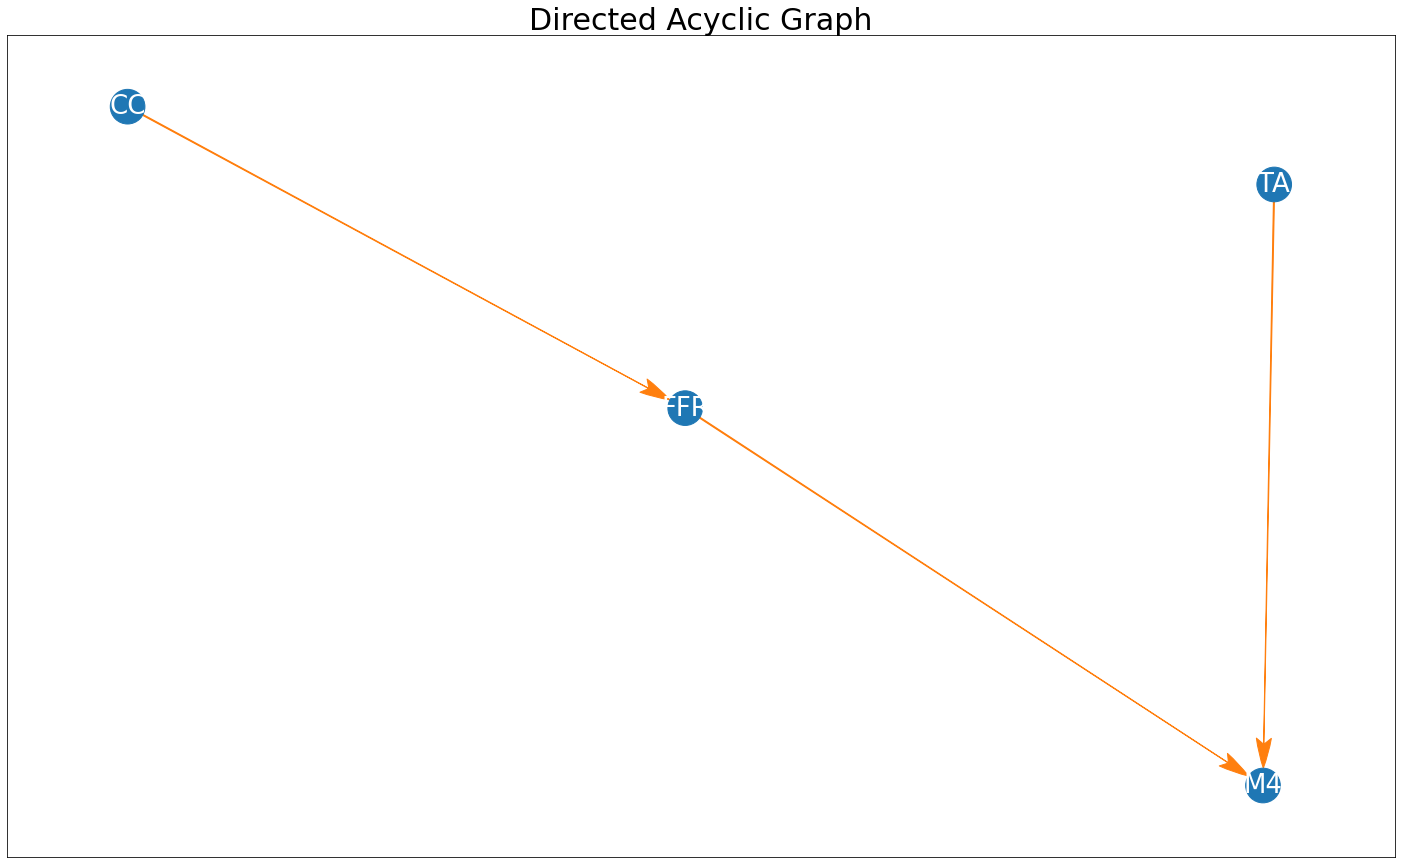

In [63]:
from matplotlib.patches import ArrowStyle

def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)

graph_DAG(edges, df, title = "Directed Acyclic Graph")
edges

keep control: FFR
('TA', 'M4') ['FFR']
keep control: TA
('FFR', 'M4') ['TA']
('CC', 'FFR') []


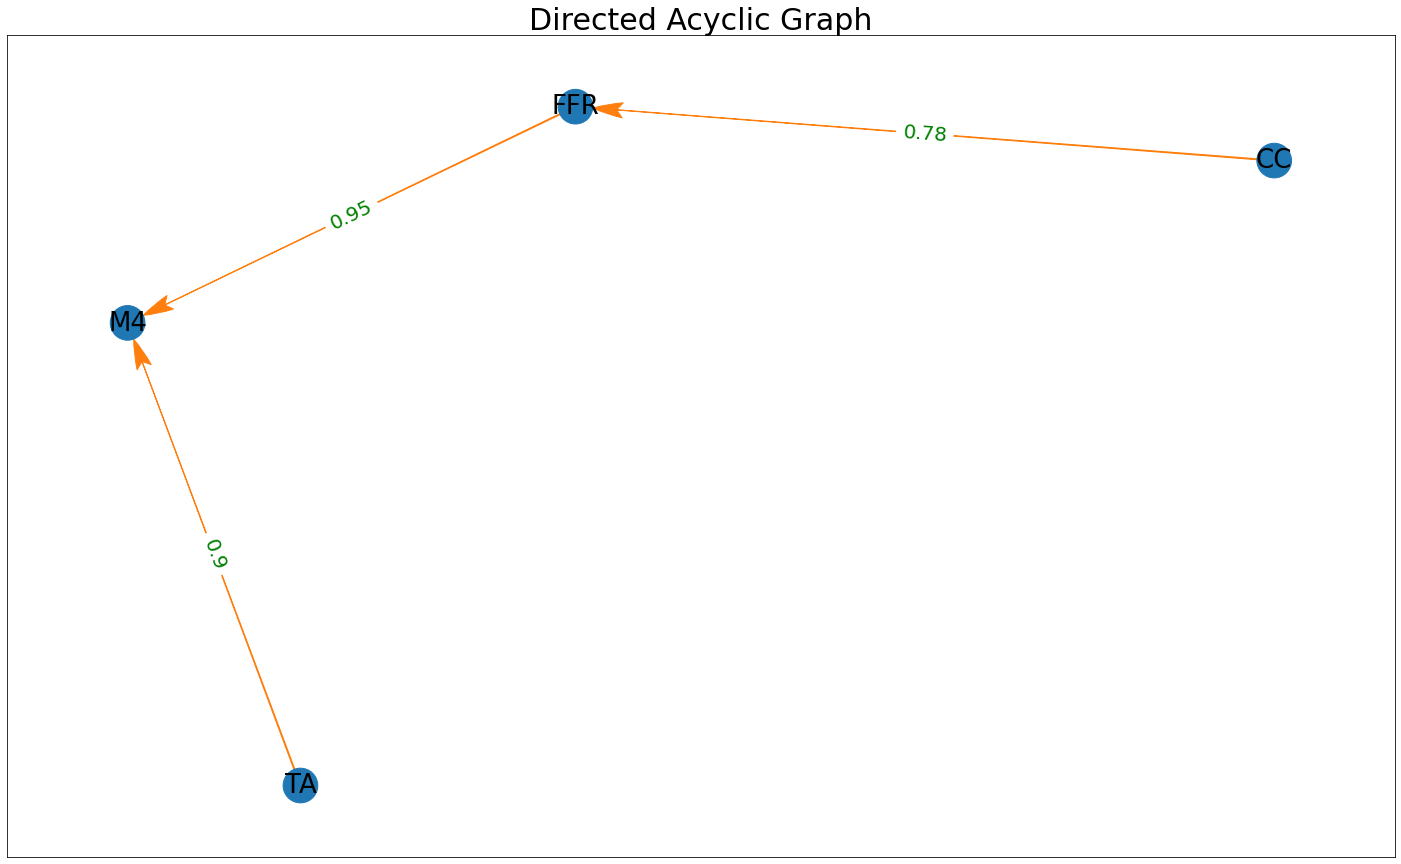

In [64]:
## D-separation

def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    edge_labels = {}
    ############ Add ############
    for edge in edges:
        controls = [key for key in df.keys() if key not in edge]
        controls = list(set(controls))
        keep_controls = []
        for control in controls:
            control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
            if (control, edge[1]) in control_edges:
                print("keep control:", control)
                keep_controls.append(control)                
        print(edge, keep_controls)
        pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#         corr_matrix_heatmap(pcorr, save_fig = False, pp = None, title = "Partial Correlation")
        edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],2))
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     # turn text black for larger variable names in homework
                     font_color = "k",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    ############ Add ############
    nx.draw_networkx_edge_labels(graph,pos,
                                edge_labels=edge_labels,
                                font_color='green',
                                font_size=20)

graph_DAG(edges, df, title = "Directed Acyclic Graph")

In [65]:
data = df
def firstLetterWord(str, num_chars = 3):
 
    result = ""
 
    # Traverse the string.
    v = True
    for i in range(len(str)):
         
        # If it is space, set v as true.
        if (str[i] == ' '):
            v = True
 
        # Else check if v is true or not.
        # If true, copy character in output
        # string and set v as false.
        elif (str[i] != ' ' and v == True):
            result += (str[i:i+num_chars])
            v = False
 
    return result

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

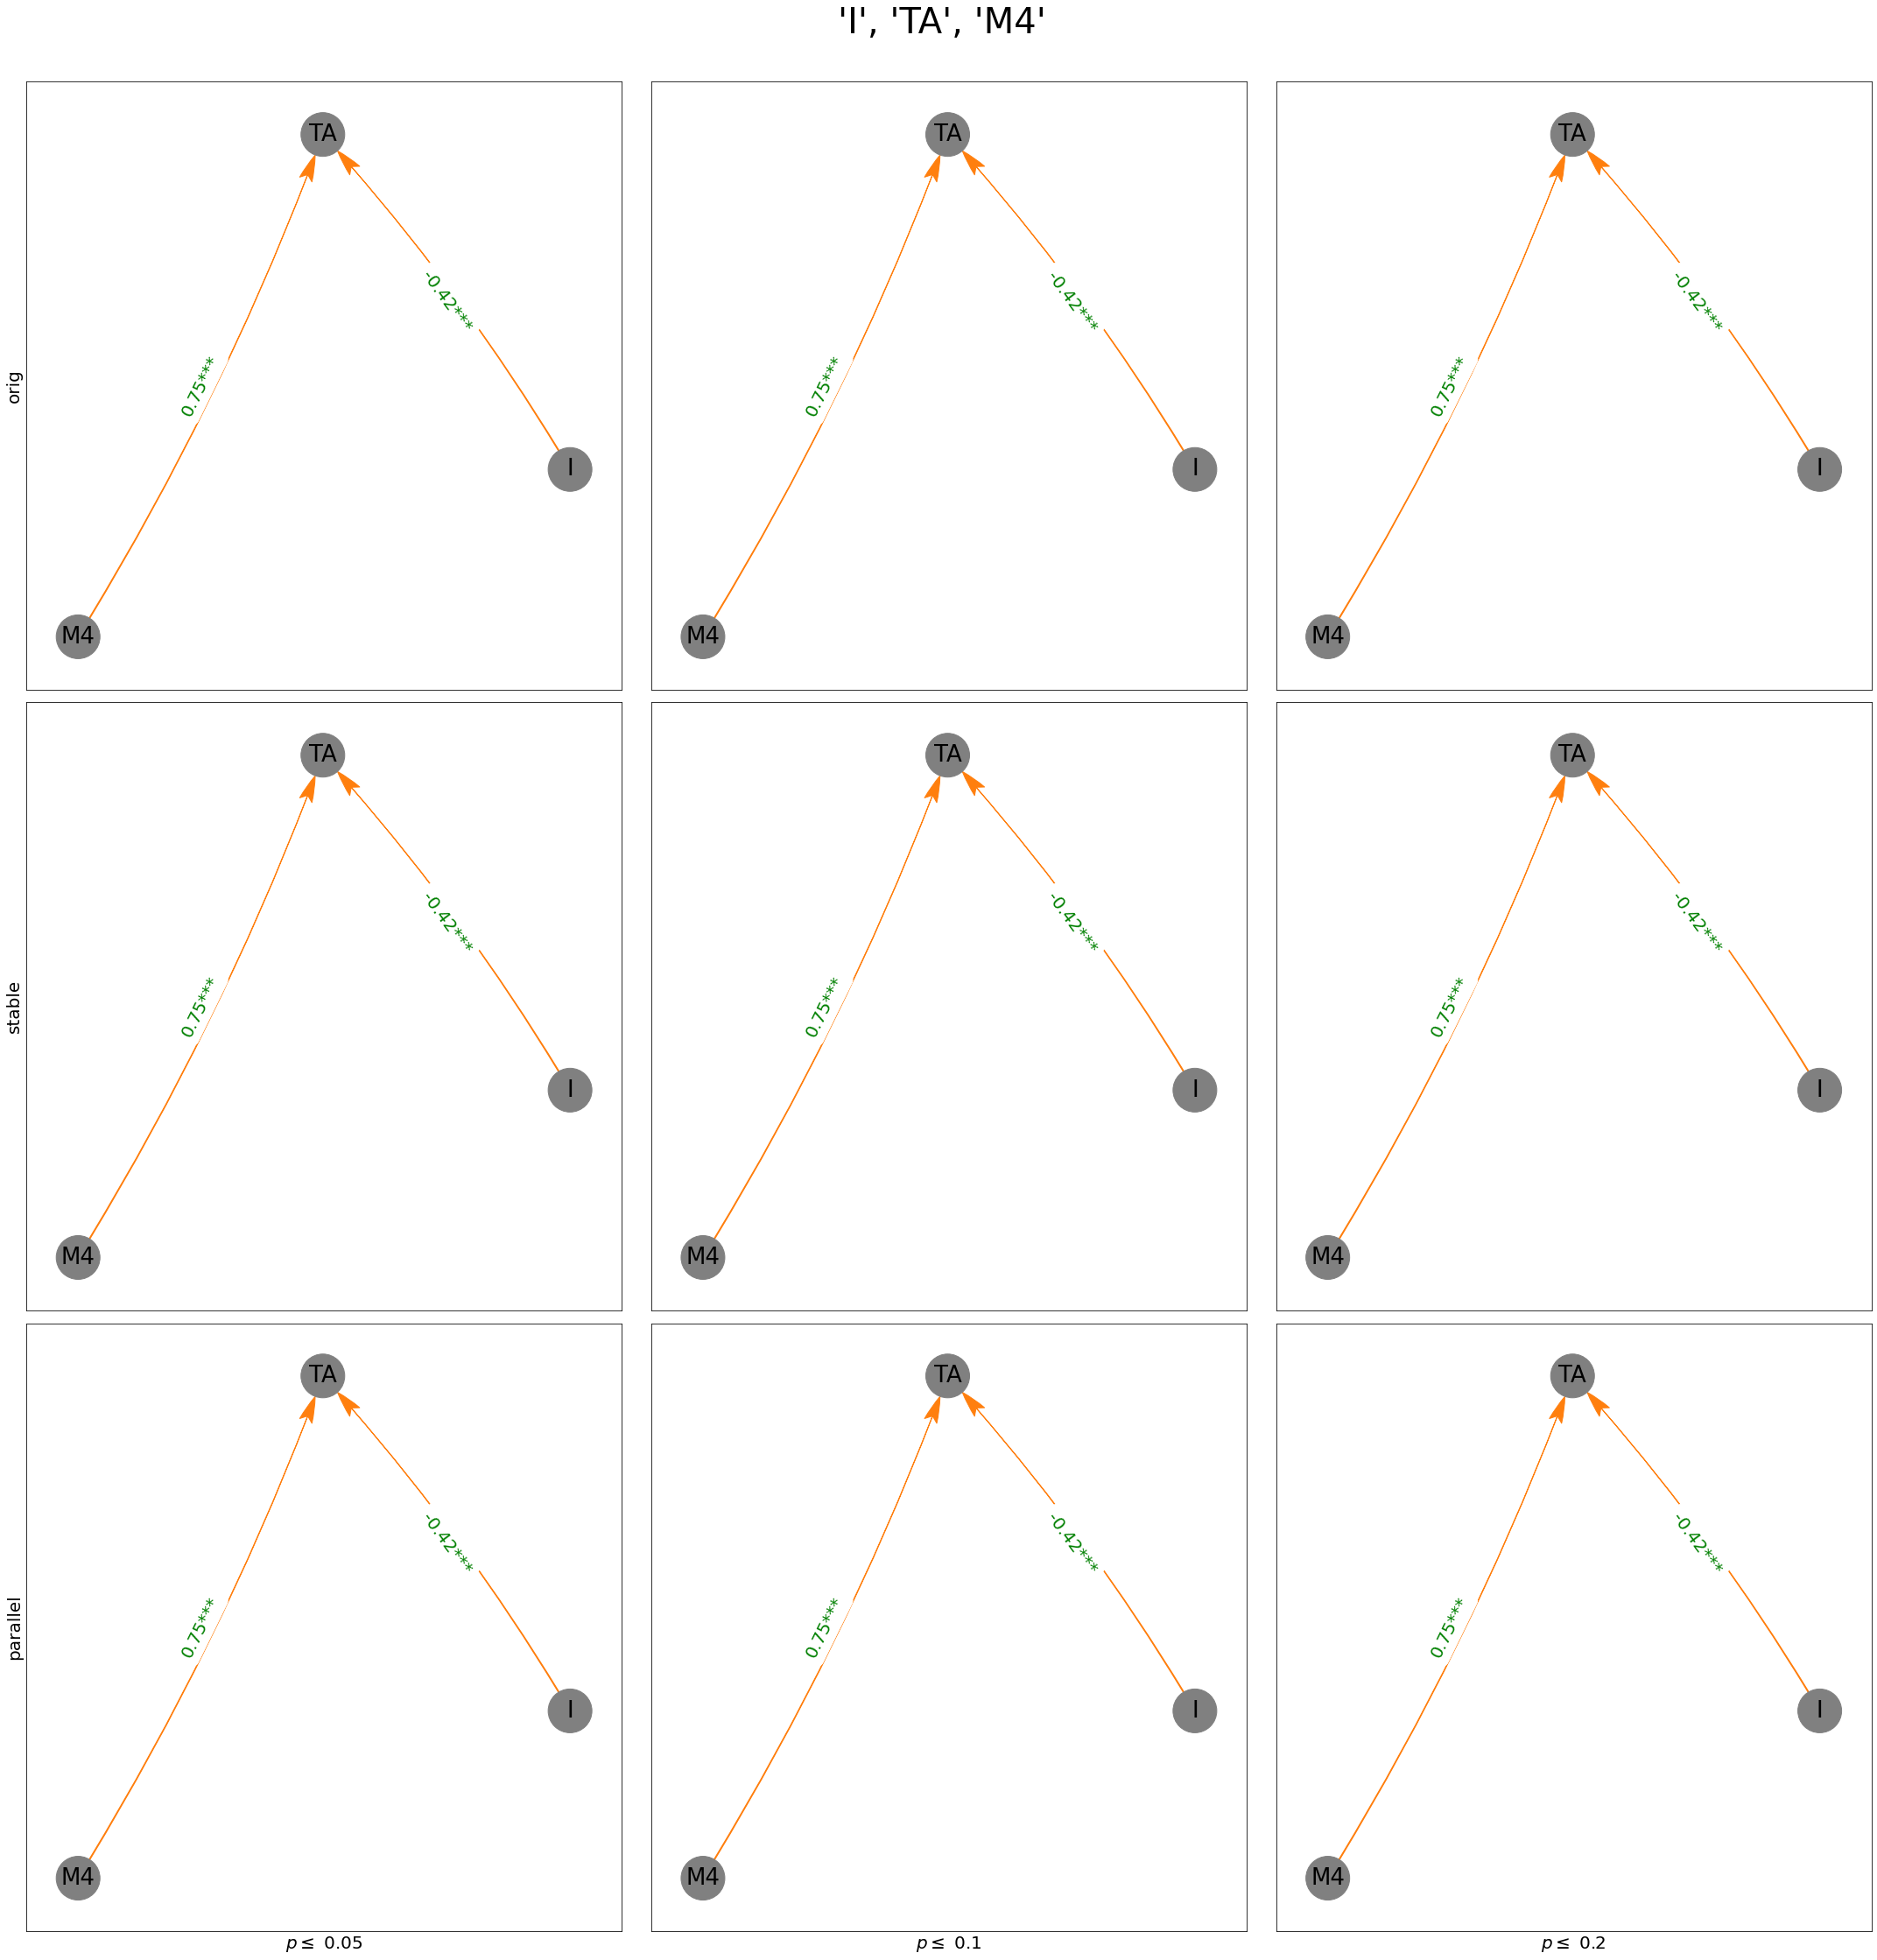

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

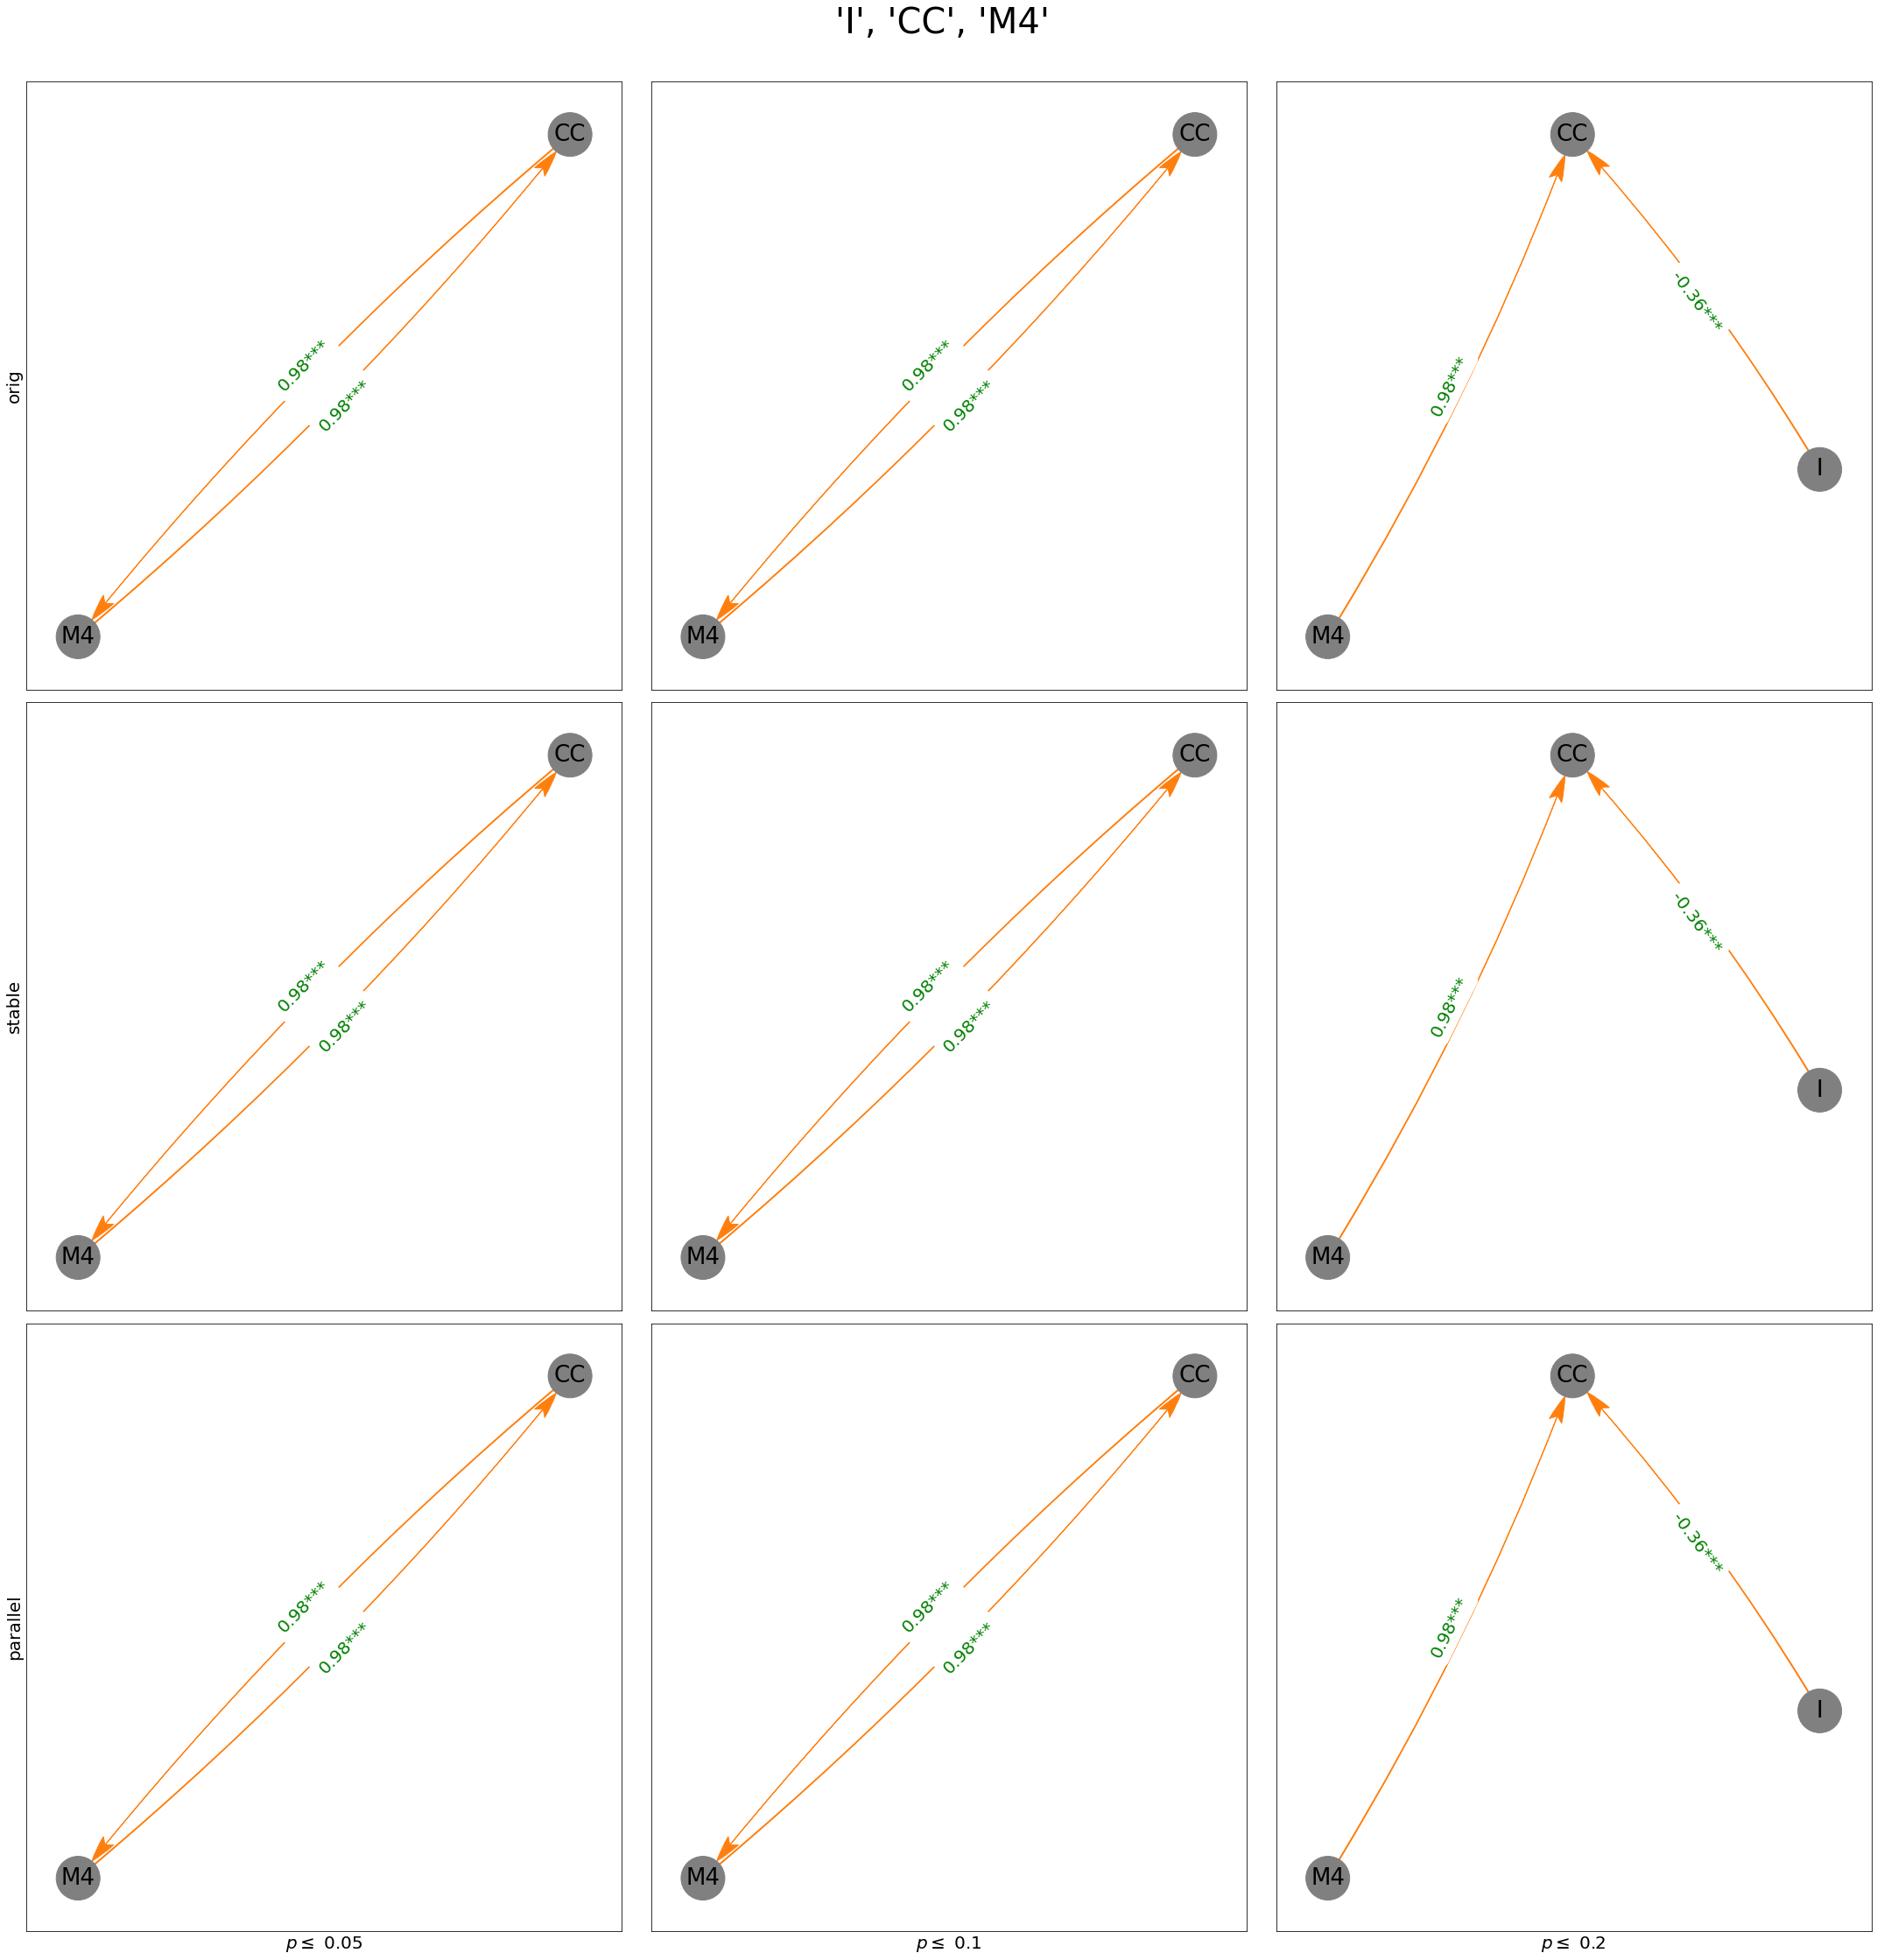

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

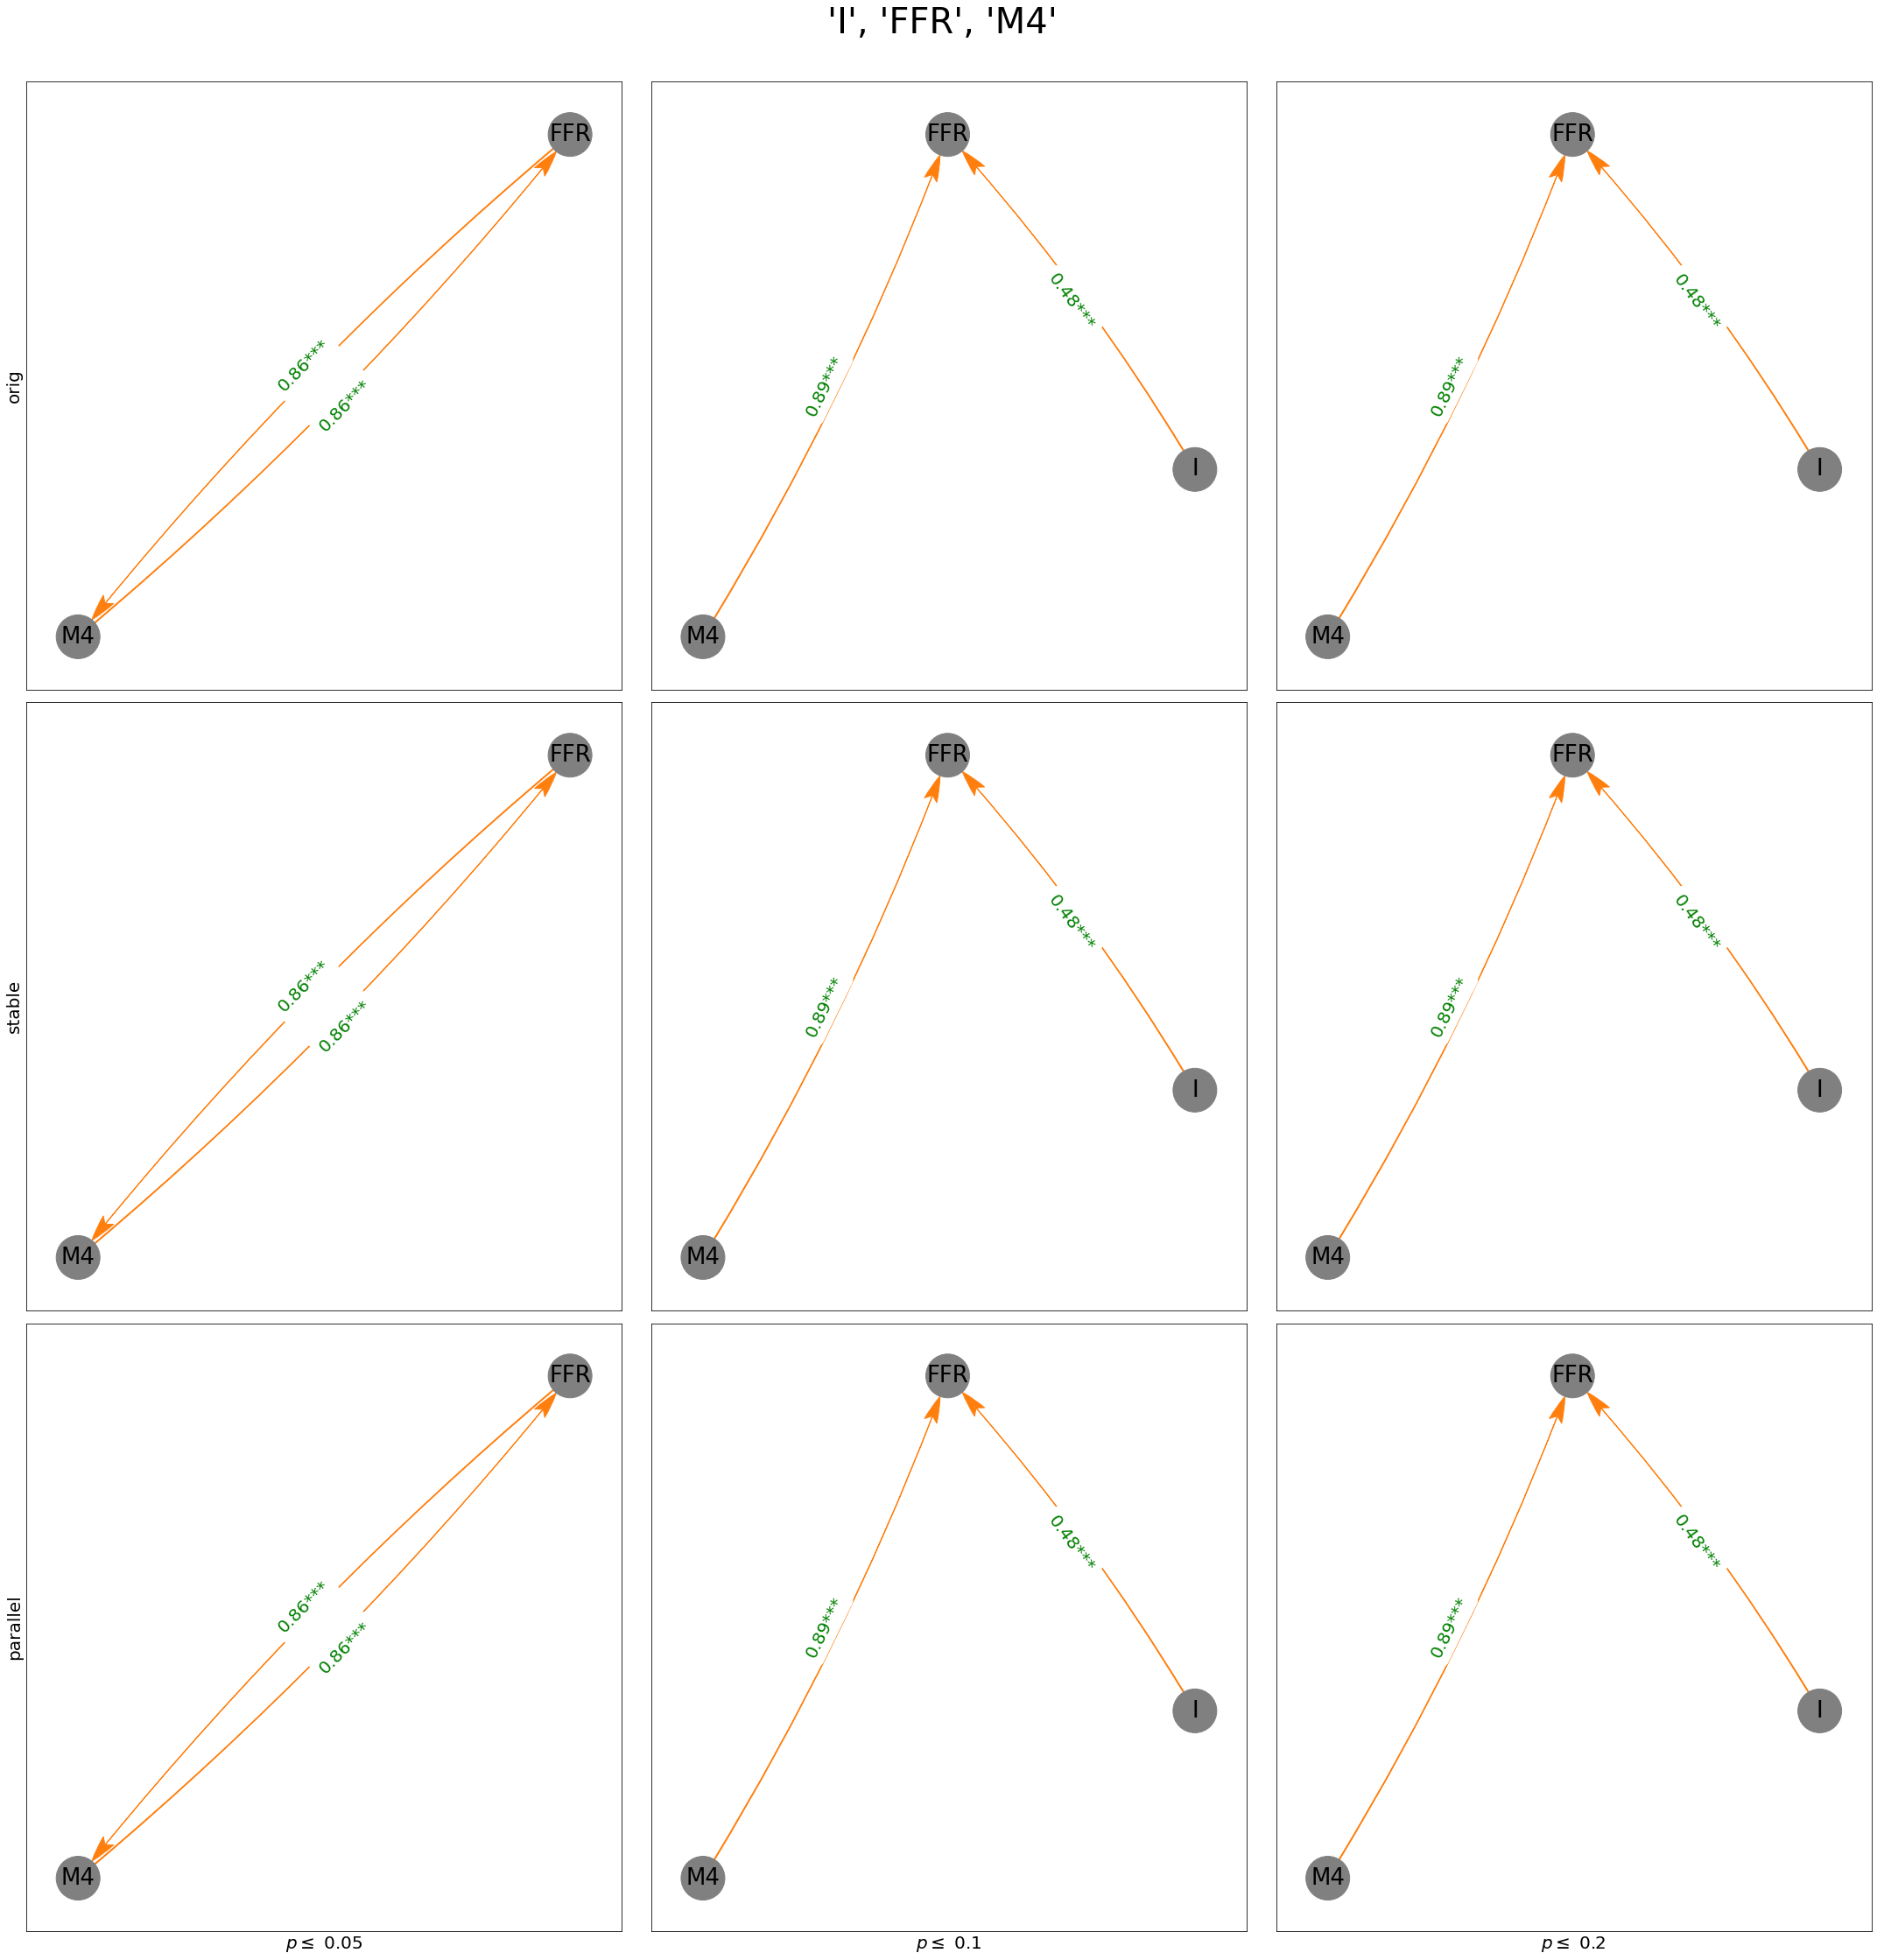

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

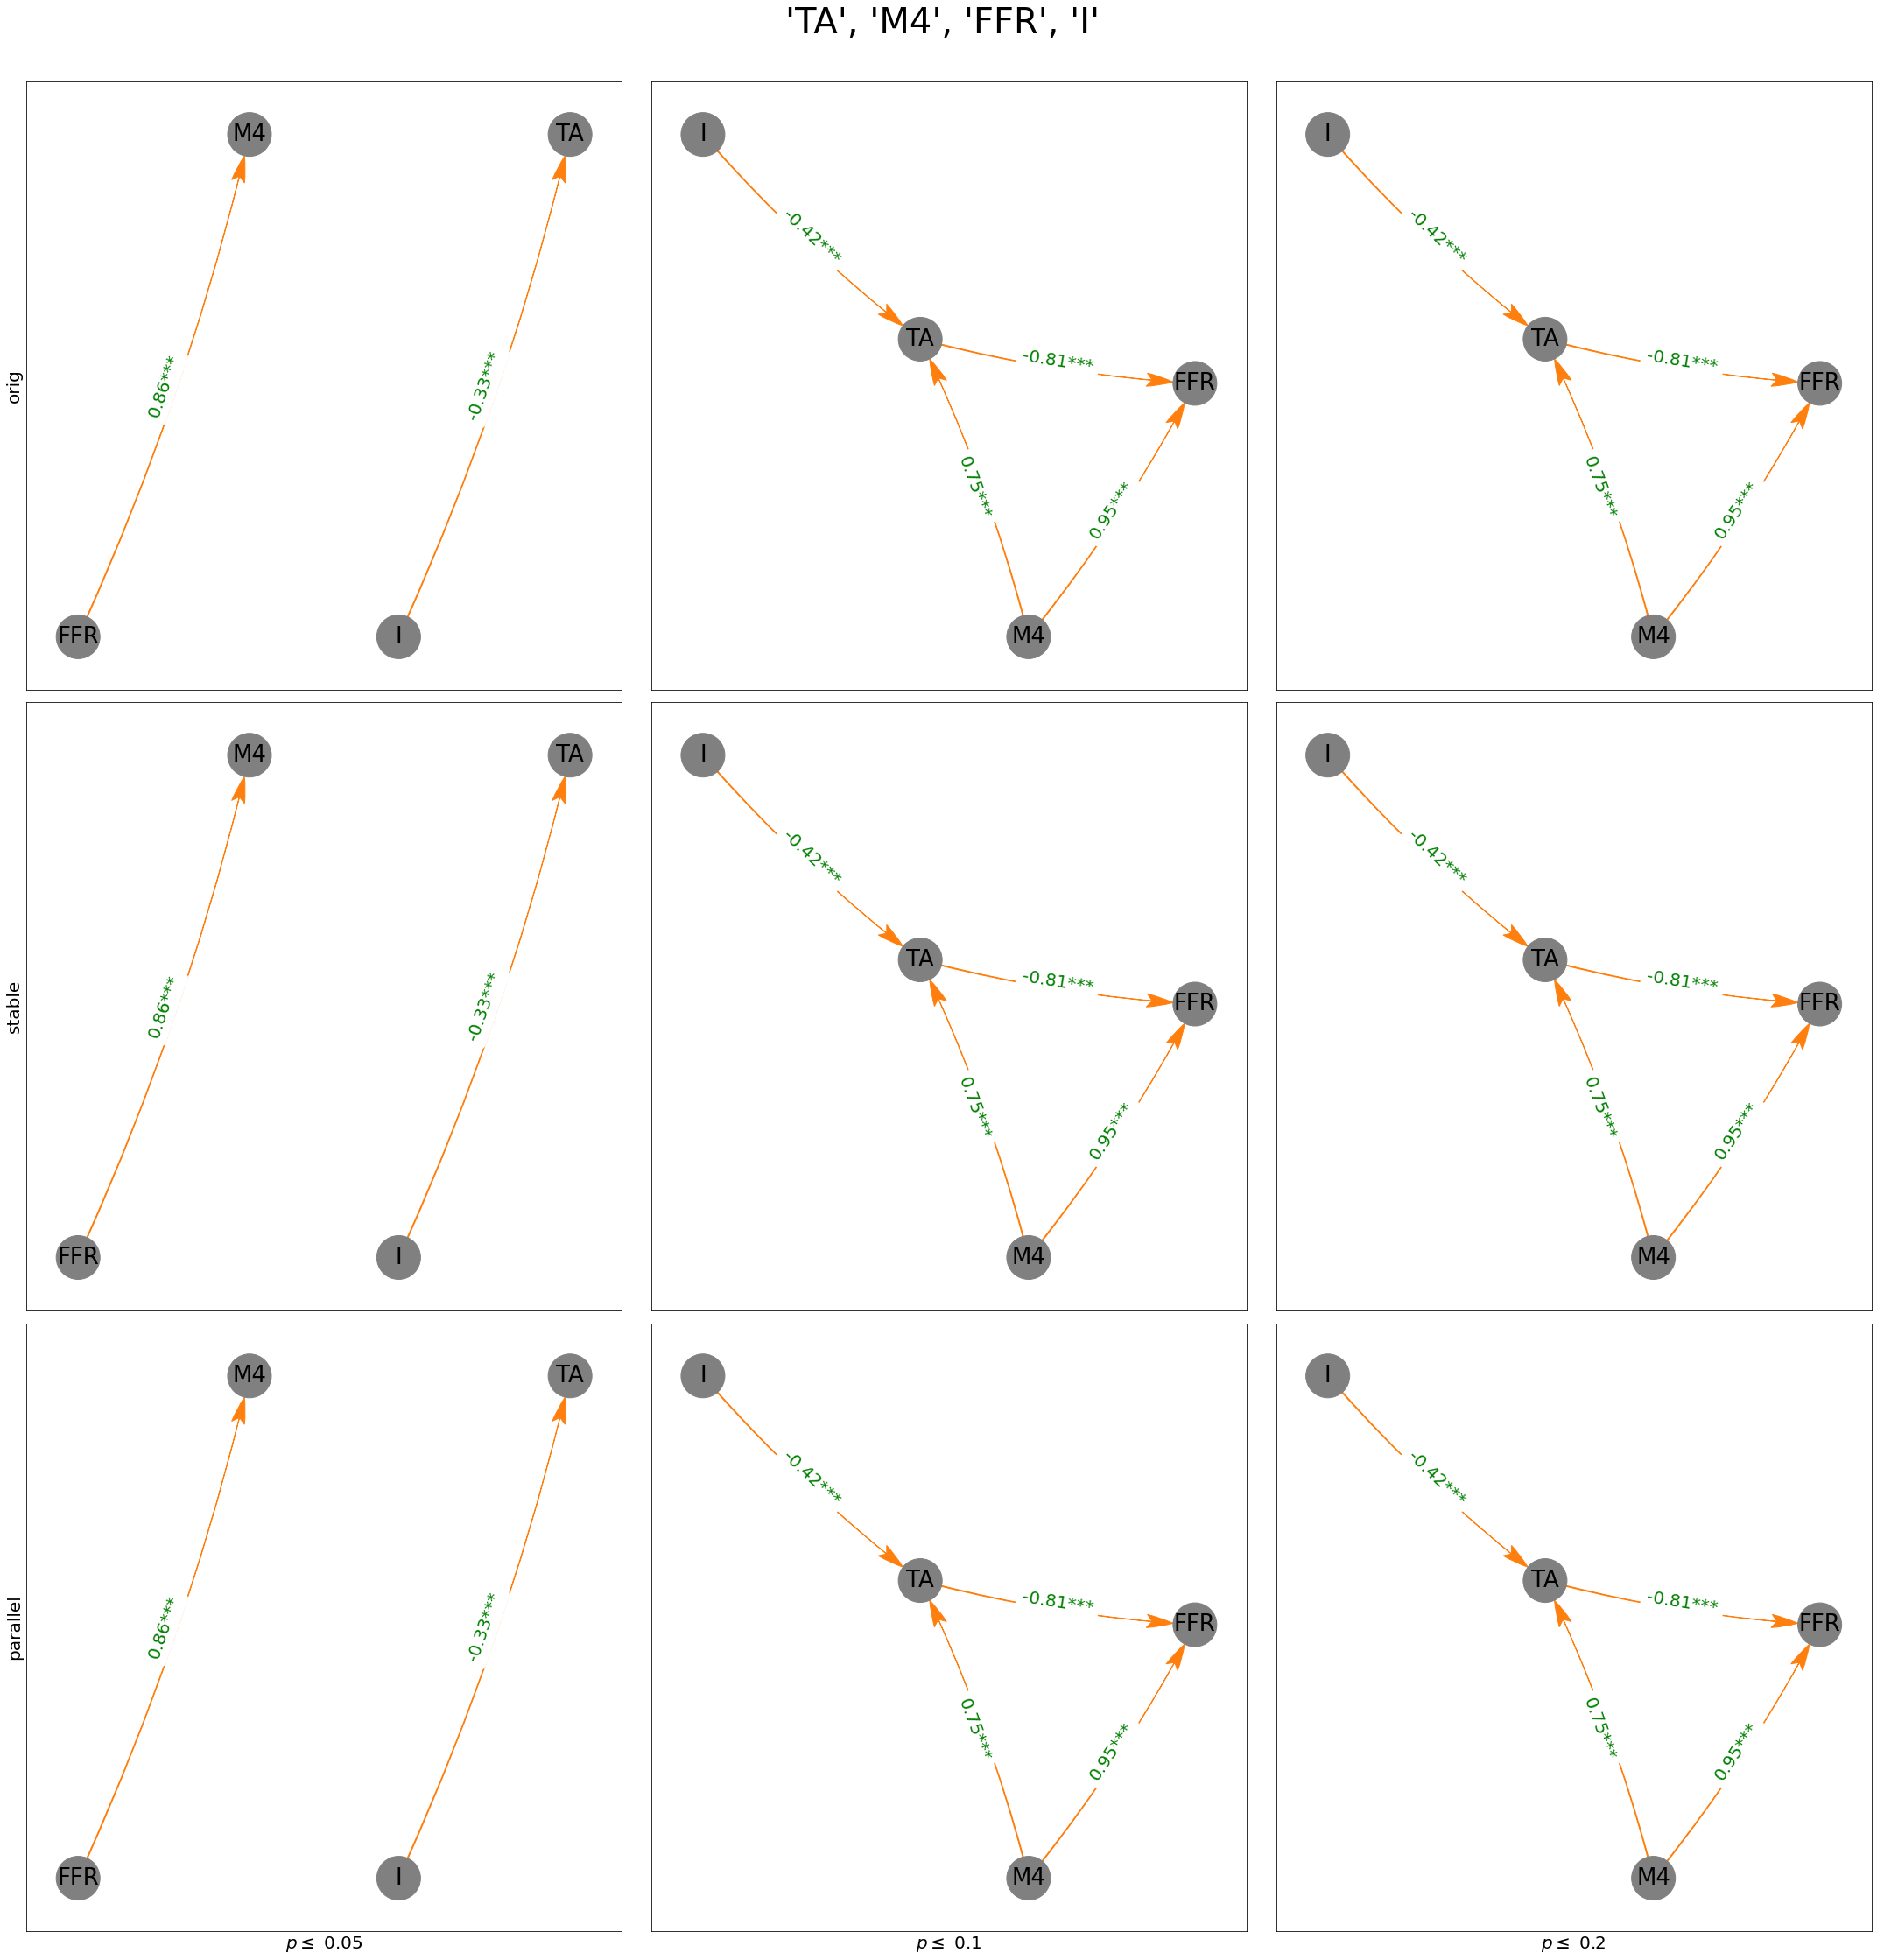

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

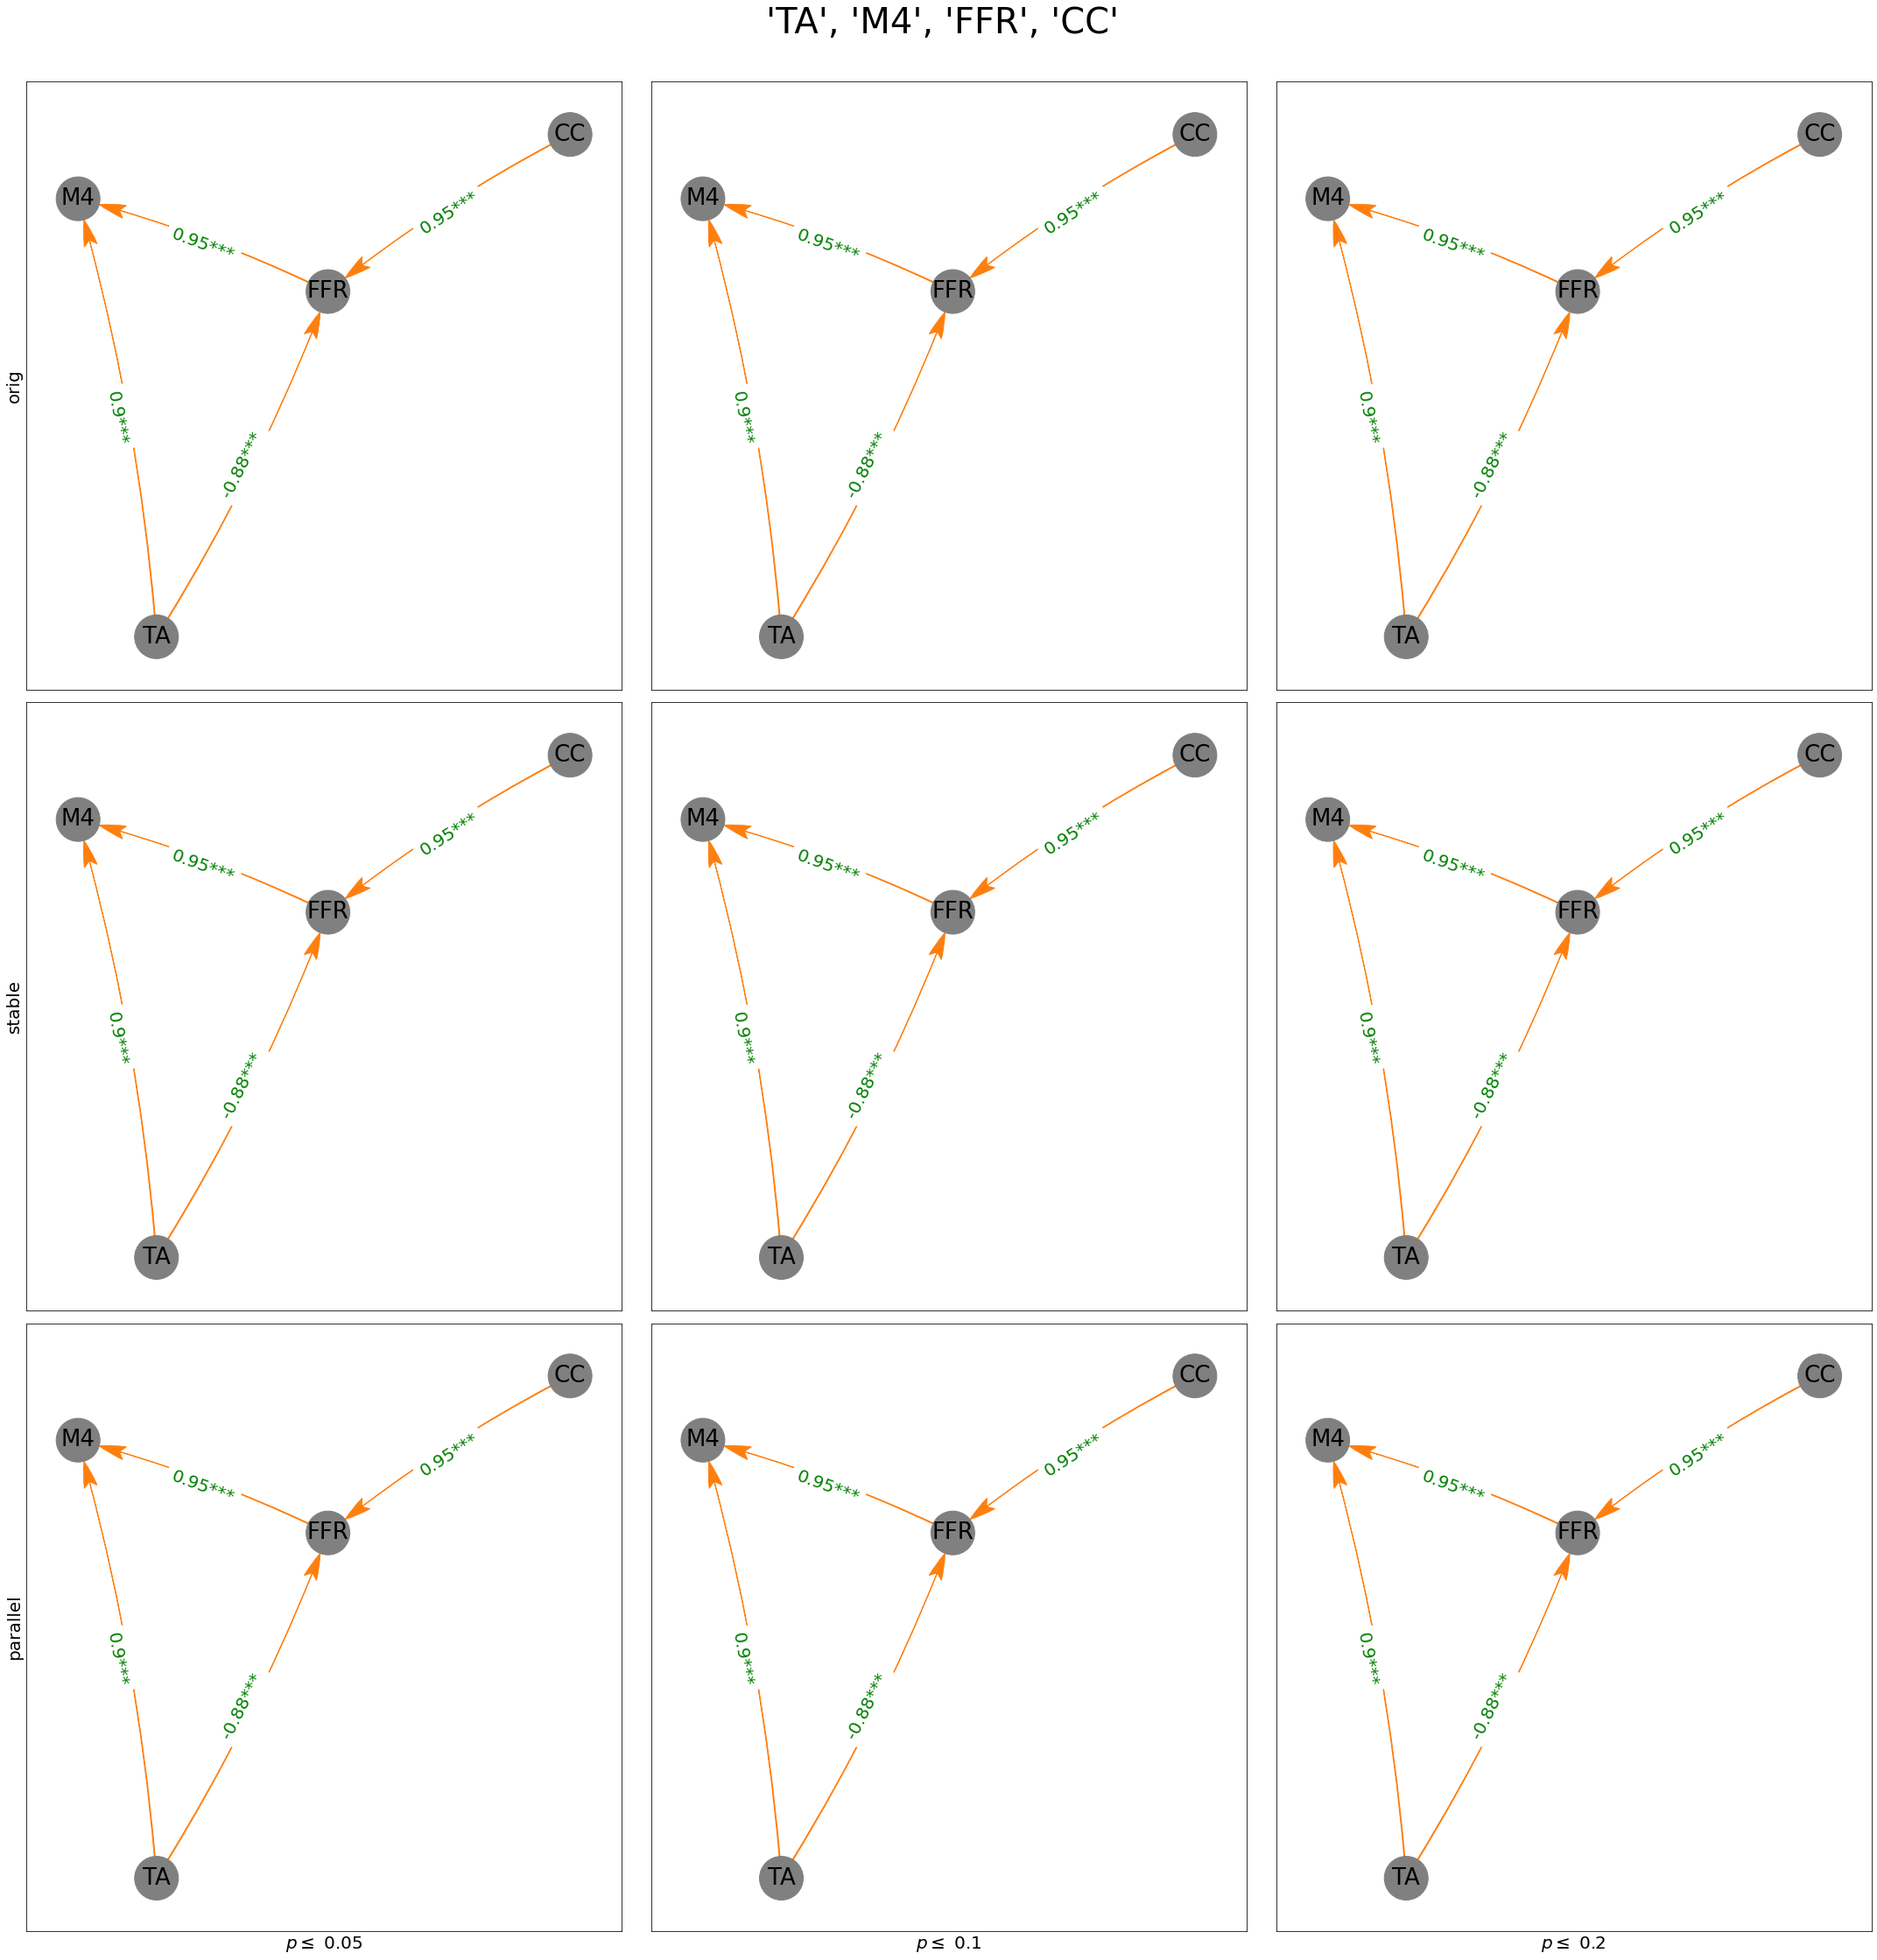

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

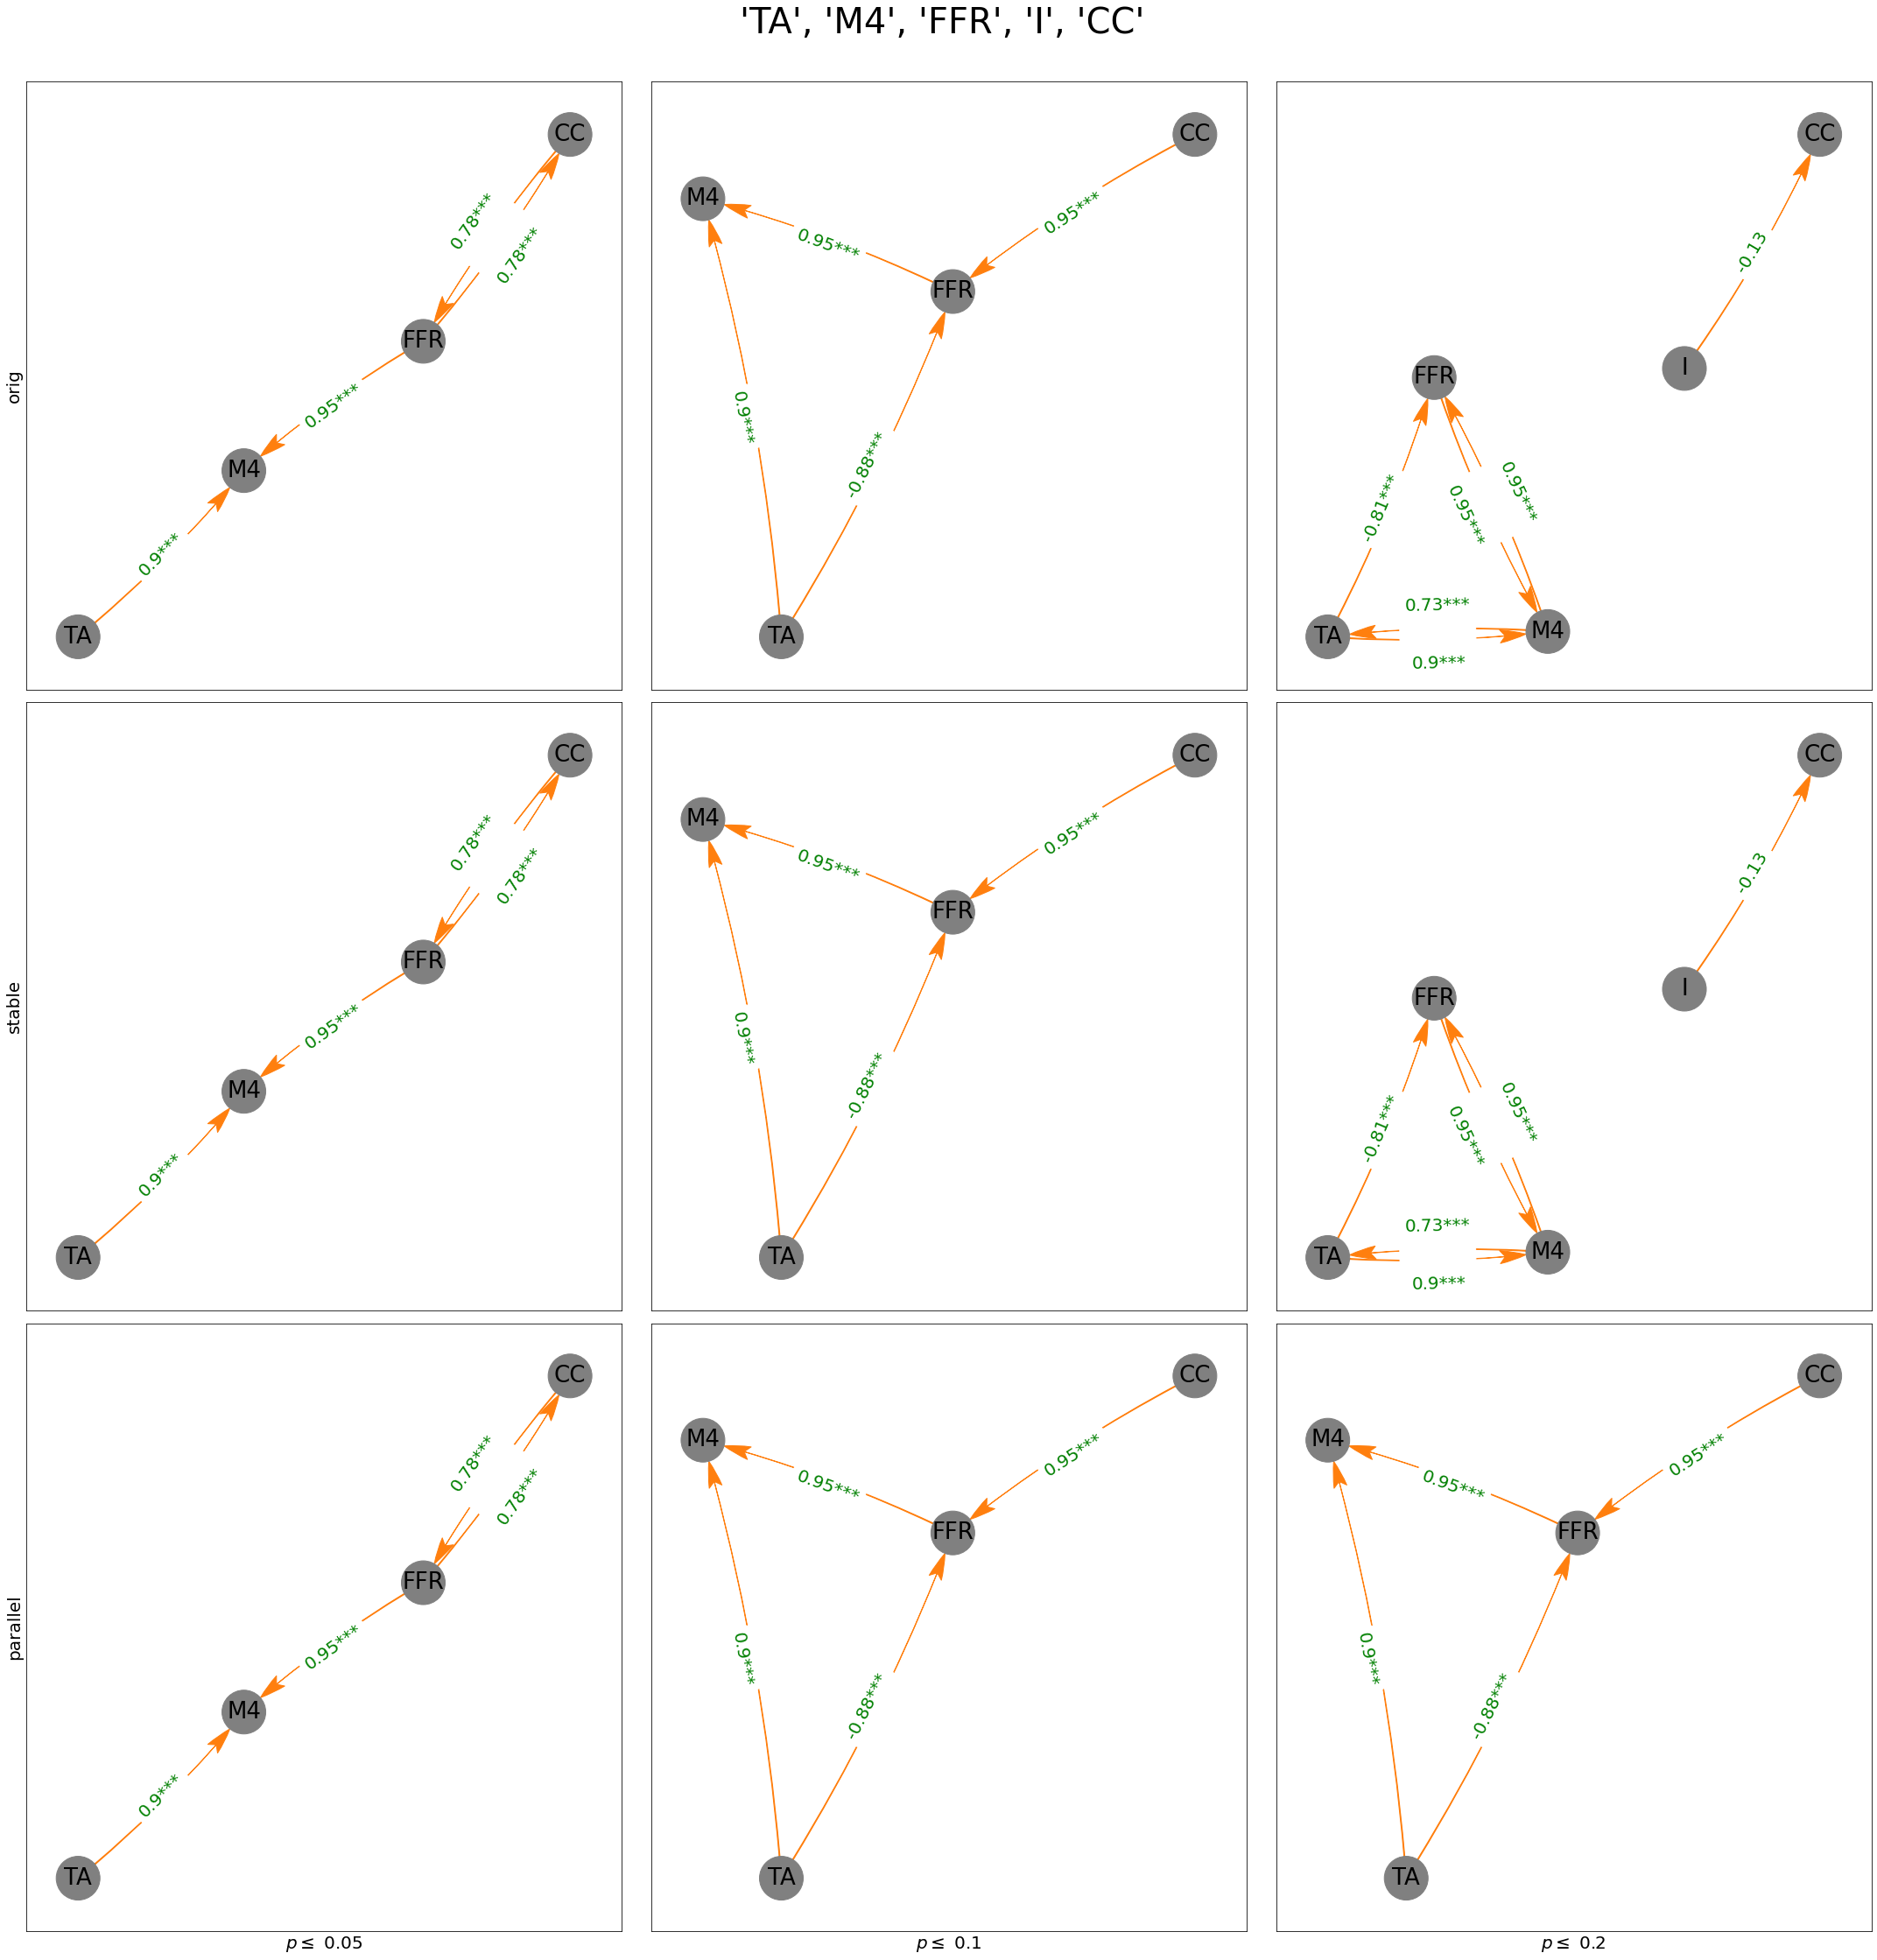

OutEdgeView([('TA', 'M4'), ('TA', 'FFR'), ('FFR', 'M4'), ('CC', 'FFR')])

In [68]:
def graph_DAG(edges, data_reg, title = "", 
              fig = False, ax = False, 
              edge_labels = False,sig_vals = [0.05, 0.01, 0.001]):
    pcorr = data_reg.pcorr()
    graph = nx.DiGraph()
    def build_edge_labels(edges, df, sig_vals):
        edge_labels = {}
        for edge in edges:
            controls = [key for key in df.keys() if key not in edge]
            controls = list(set(controls))
            keep_controls = []
            for control in controls:
                control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
                if (control, edge[1]) in control_edges:
                    keep_controls.append(control)                
#             print(edge, keep_controls)
            pcorr = df.partial_corr(x = edge[0], y = edge[1], covar=keep_controls,
                                  method = "pearson")
            label = str(round(pcorr["r"][0],2))
            pvalue = pcorr["p-val"][0]
#             pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#             label = pcorr[edge[0]].loc[edge[1]]

            for sig_val in sig_vals:
                if pvalue < sig_val: 
                    label = label + "*"   
            
            edge_labels[edge] = label
        return edge_labels
    
    if edge_labels == False:
        edge_labels = build_edge_labels(edges, 
                                        data_reg, 
                                        sig_vals=sig_vals) 
    graph.add_edges_from(edges)
    color_map = ["grey" for g in graph]

    if fig == False and ax == False: fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    #pos = nx.spring_layout(graph)
    pos = graphviz_layout(graph)

    edge_labels2 = []
    for u, v, d in graph.edges(data=True):
        if pos[u][0] > pos[v][0]:  
            if (v,u) in edge_labels.keys():
                edge_labels2.append(((u, v,), f'{edge_labels[u,v]}\n\n\n{edge_labels[(v,u)]}'))  
        if (v,u) not in edge_labels.keys():
            edge_labels2.append(((u,v,), f'{edge_labels[(u,v)]}'))
    edge_labels = dict(edge_labels2)

    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 2500,
                     with_labels=True,  arrows=True,
                     font_color = "black",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                     connectionstyle='arc3, rad = 0.05',
                     ax = a)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20,
                                ax = a)
    

DAG_models_vars = {0:["I", "TA", "M4"],
                  1:["I", "CC", "M4"],
                  2:["I", "FFR", "M4"],
                  3:["TA", "M4", "FFR", "I"],
                  4:["TA", "M4", "FFR", "CC"],
                  5:["TA", "M4", "FFR", "I","CC"]}
# link_sigs = [0.05, 0.1, 0.2]
link_sigs = [0.05, .1, .2]
algorithms = ["orig", "stable", "parallel"]
for keys in DAG_models_vars.values():
    fig, ax = plt.subplots(len(algorithms), len(link_sigs), figsize = (30,30))
    max_cond_vars = len(keys) - 2
    data_reg = data[keys].dropna()
    data_reg.rename(columns = {col:firstLetterWord(col) for col in keys}, inplace = True)
    keys = data_reg.keys()
    c = PC(data_reg[keys].dropna())
    max_cond_vars = len(keys) - 2
    i,j = 0,0
    for sig in link_sigs:
        for algorithm in algorithms:
            model = c.estimate(return_type = "pdag", variant = algorithm, 
                               significance_level = sig, 
                               max_cond_vars = max_cond_vars, ci_test = "pearsonr")
            edges = model.edges()
            pcorr = data_reg.pcorr()
            weights = {}
            a = ax[i][j]
            graph_DAG(edges, data_reg, fig = fig, ax = a)
        
            if j == 0:
                a.set_ylabel(algorithm, fontsize = 20)
            if i == len(algorithms) - 1:
                a.set_xlabel("$p \leq$ "+ str(sig), fontsize = 20)
            i += 1
        j += 1
        i = 0
    plt.suptitle(str(list(keys)).replace("[","").replace("]",""), fontsize = 40, y =1.035)
    plt.show()
    plt.close()
edges

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

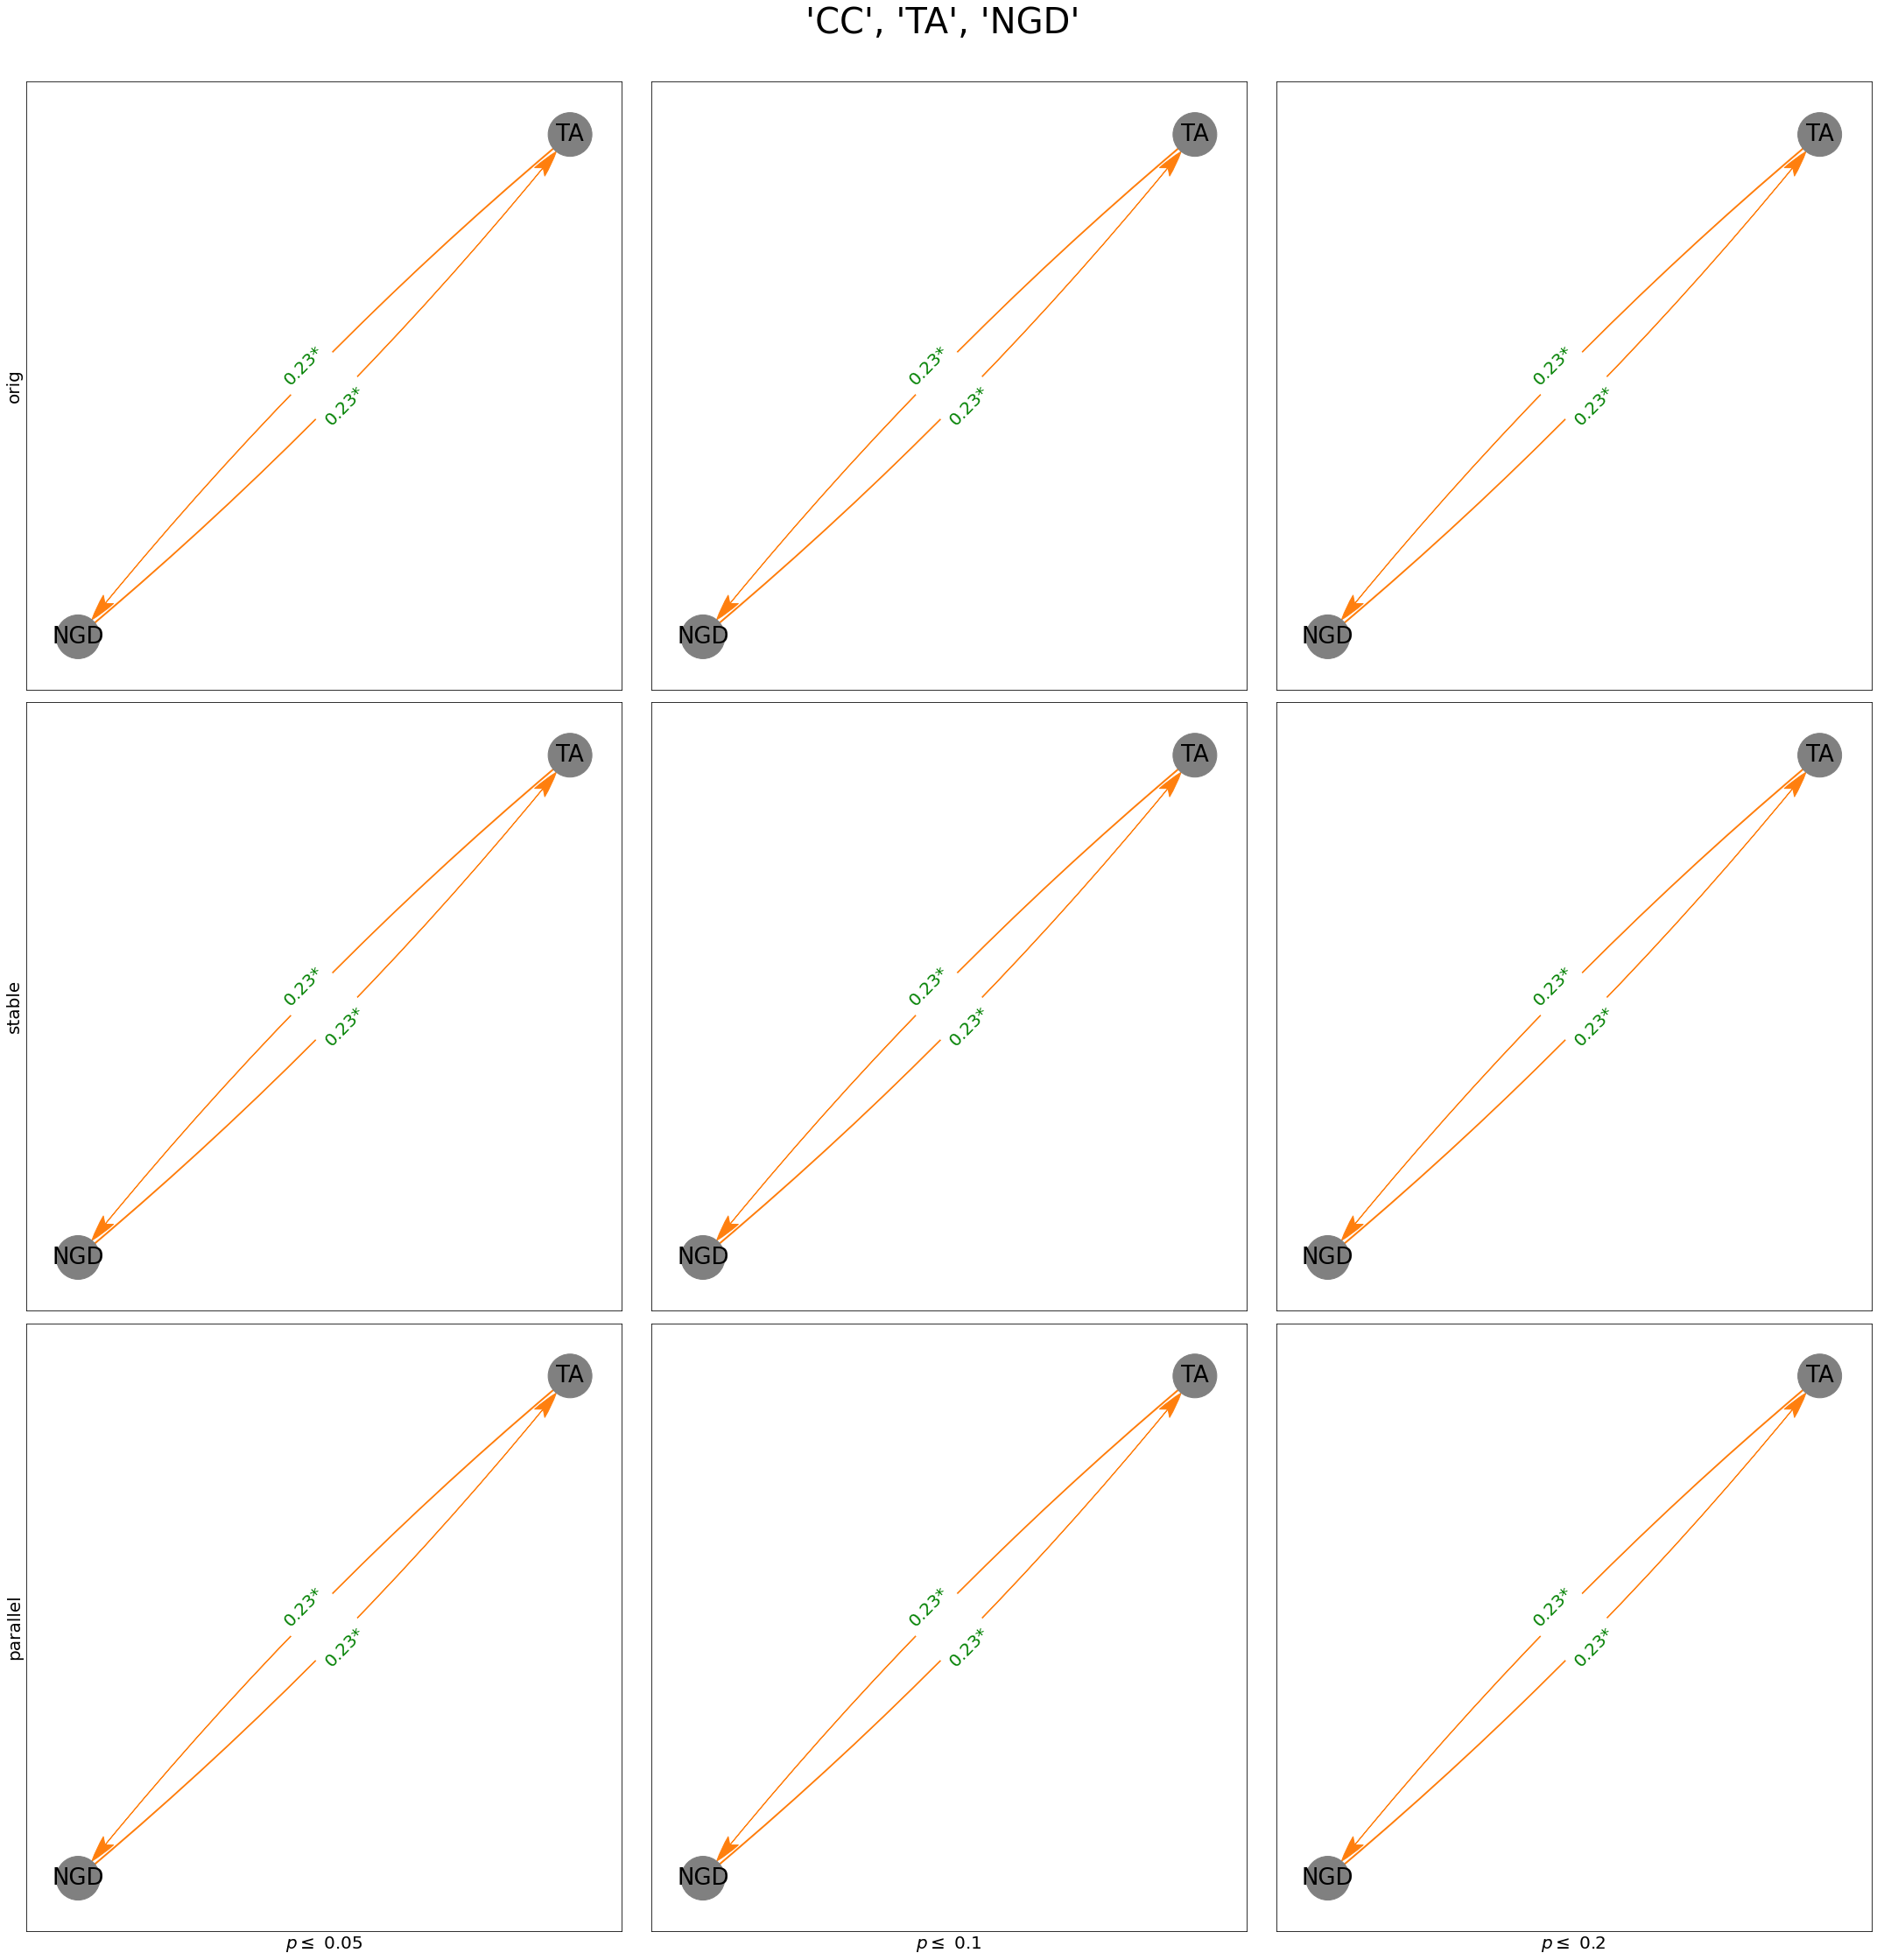

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

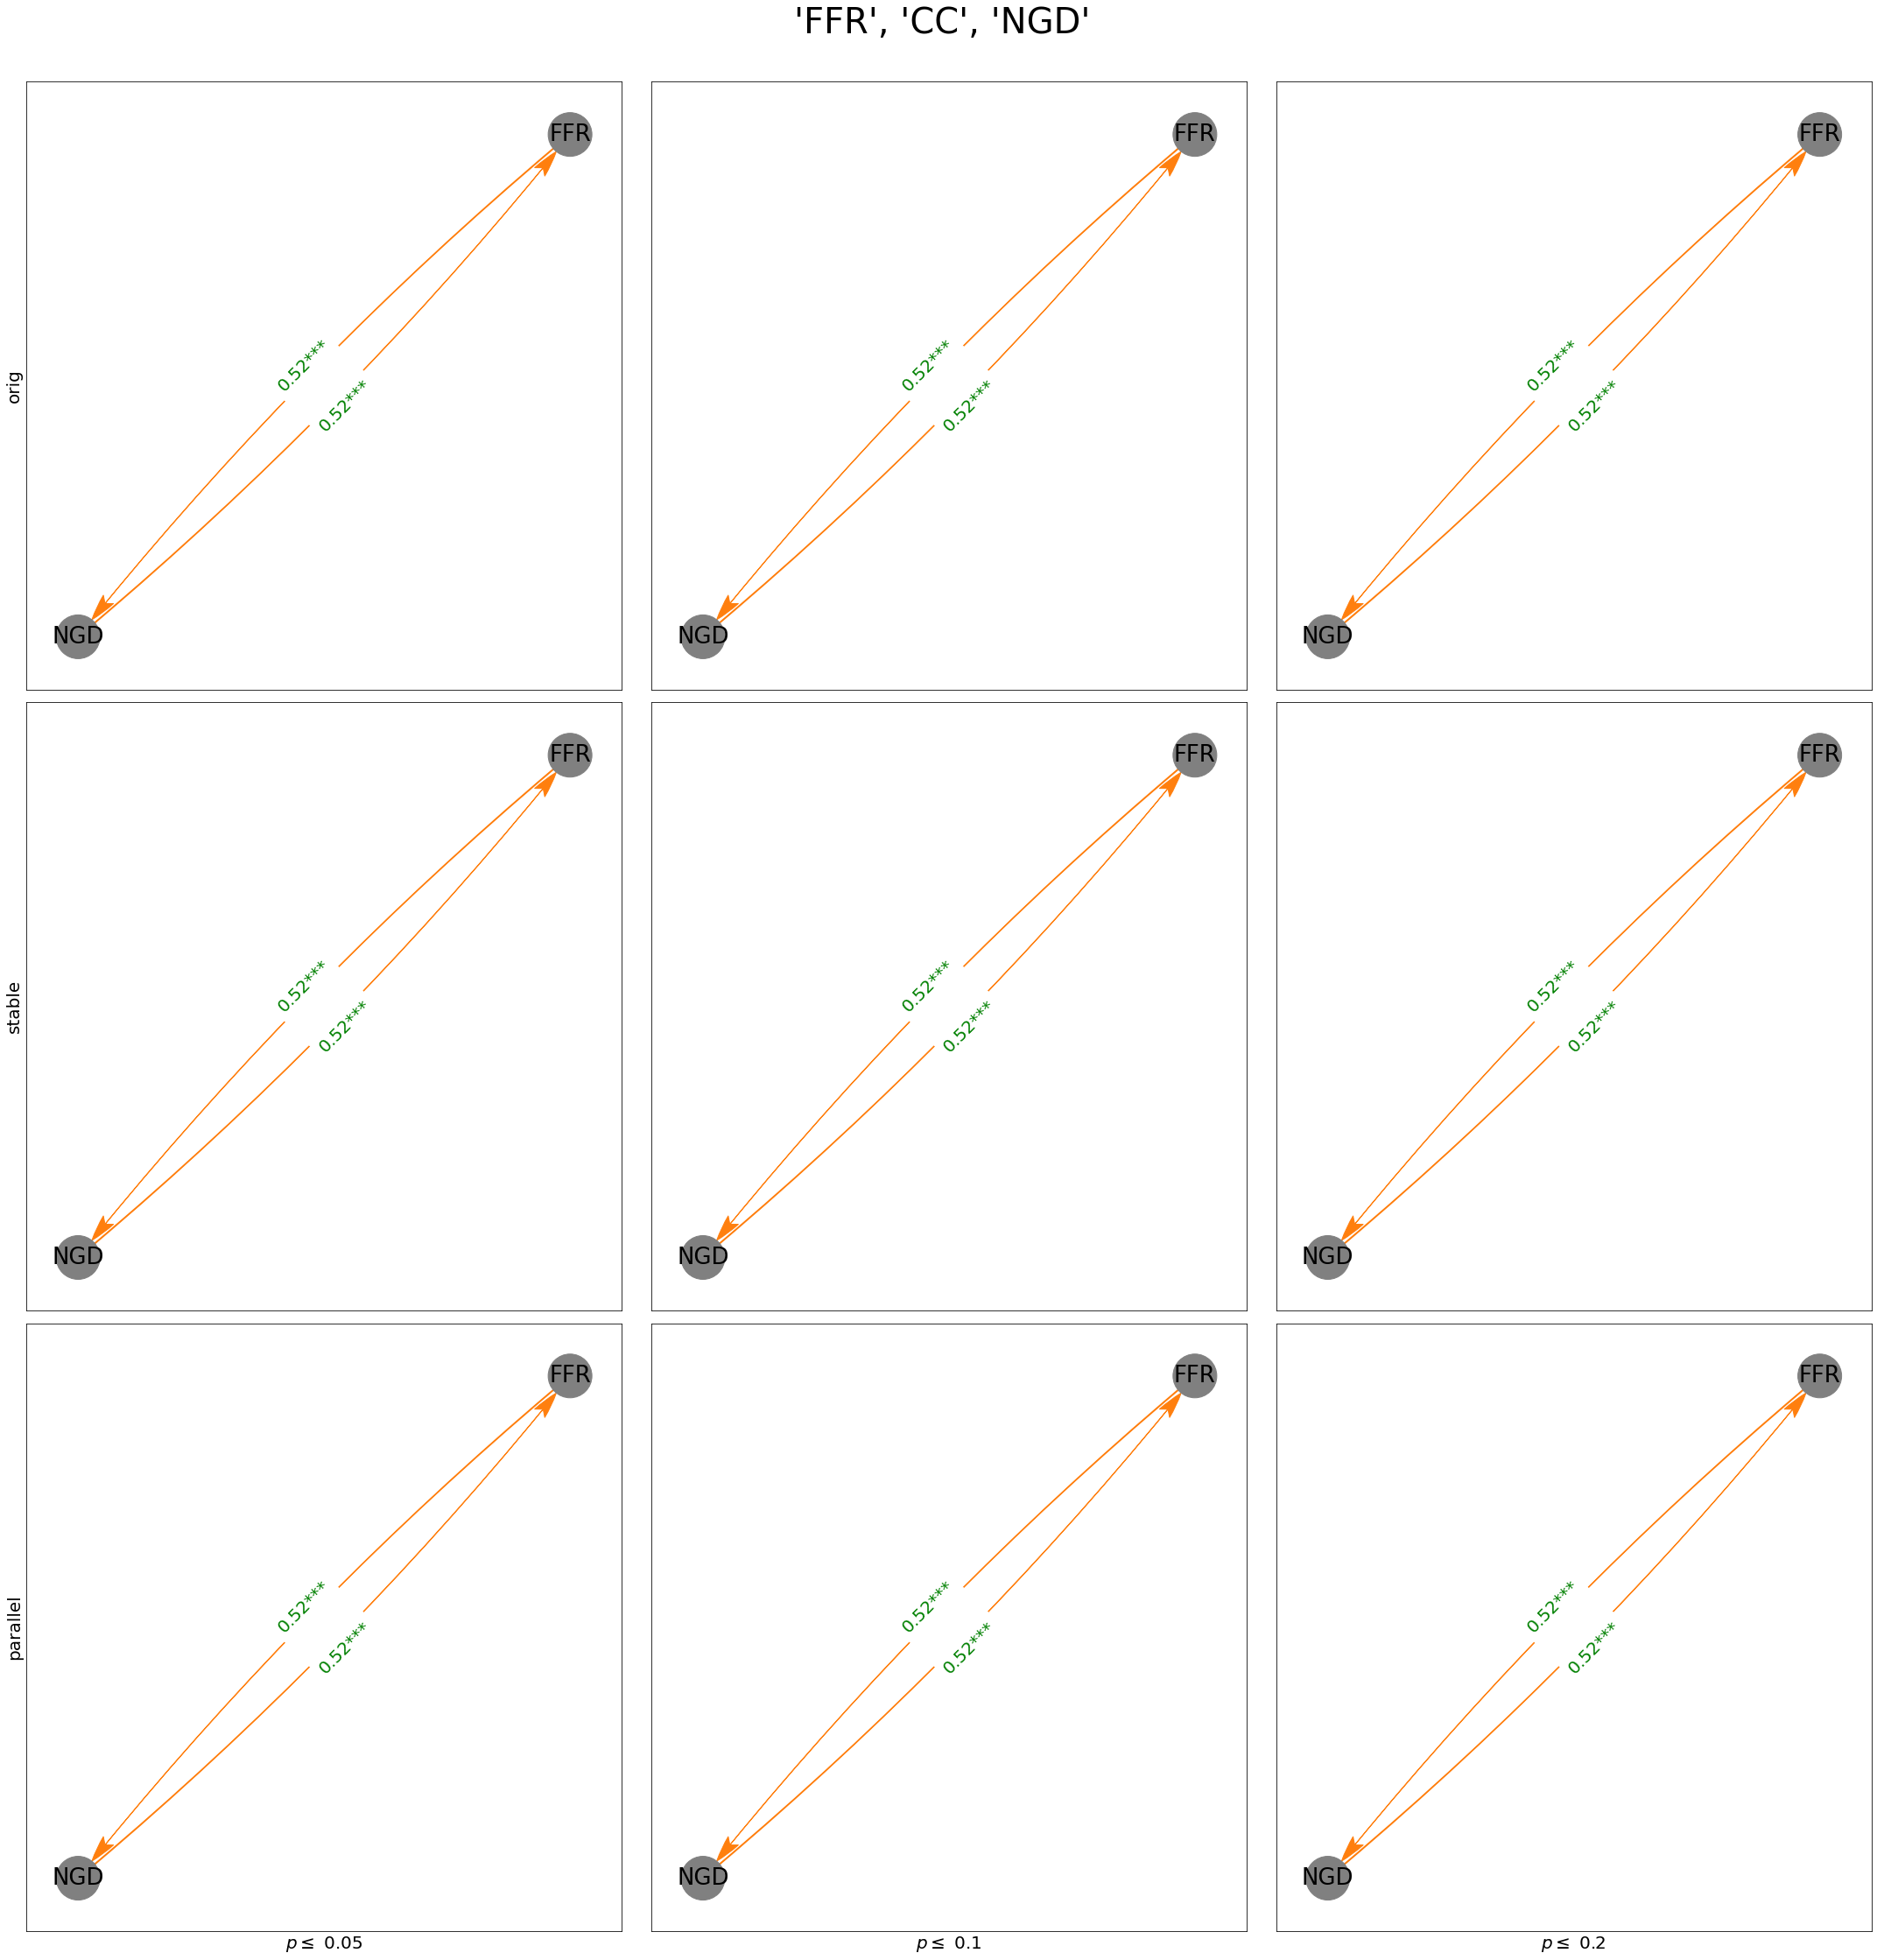

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

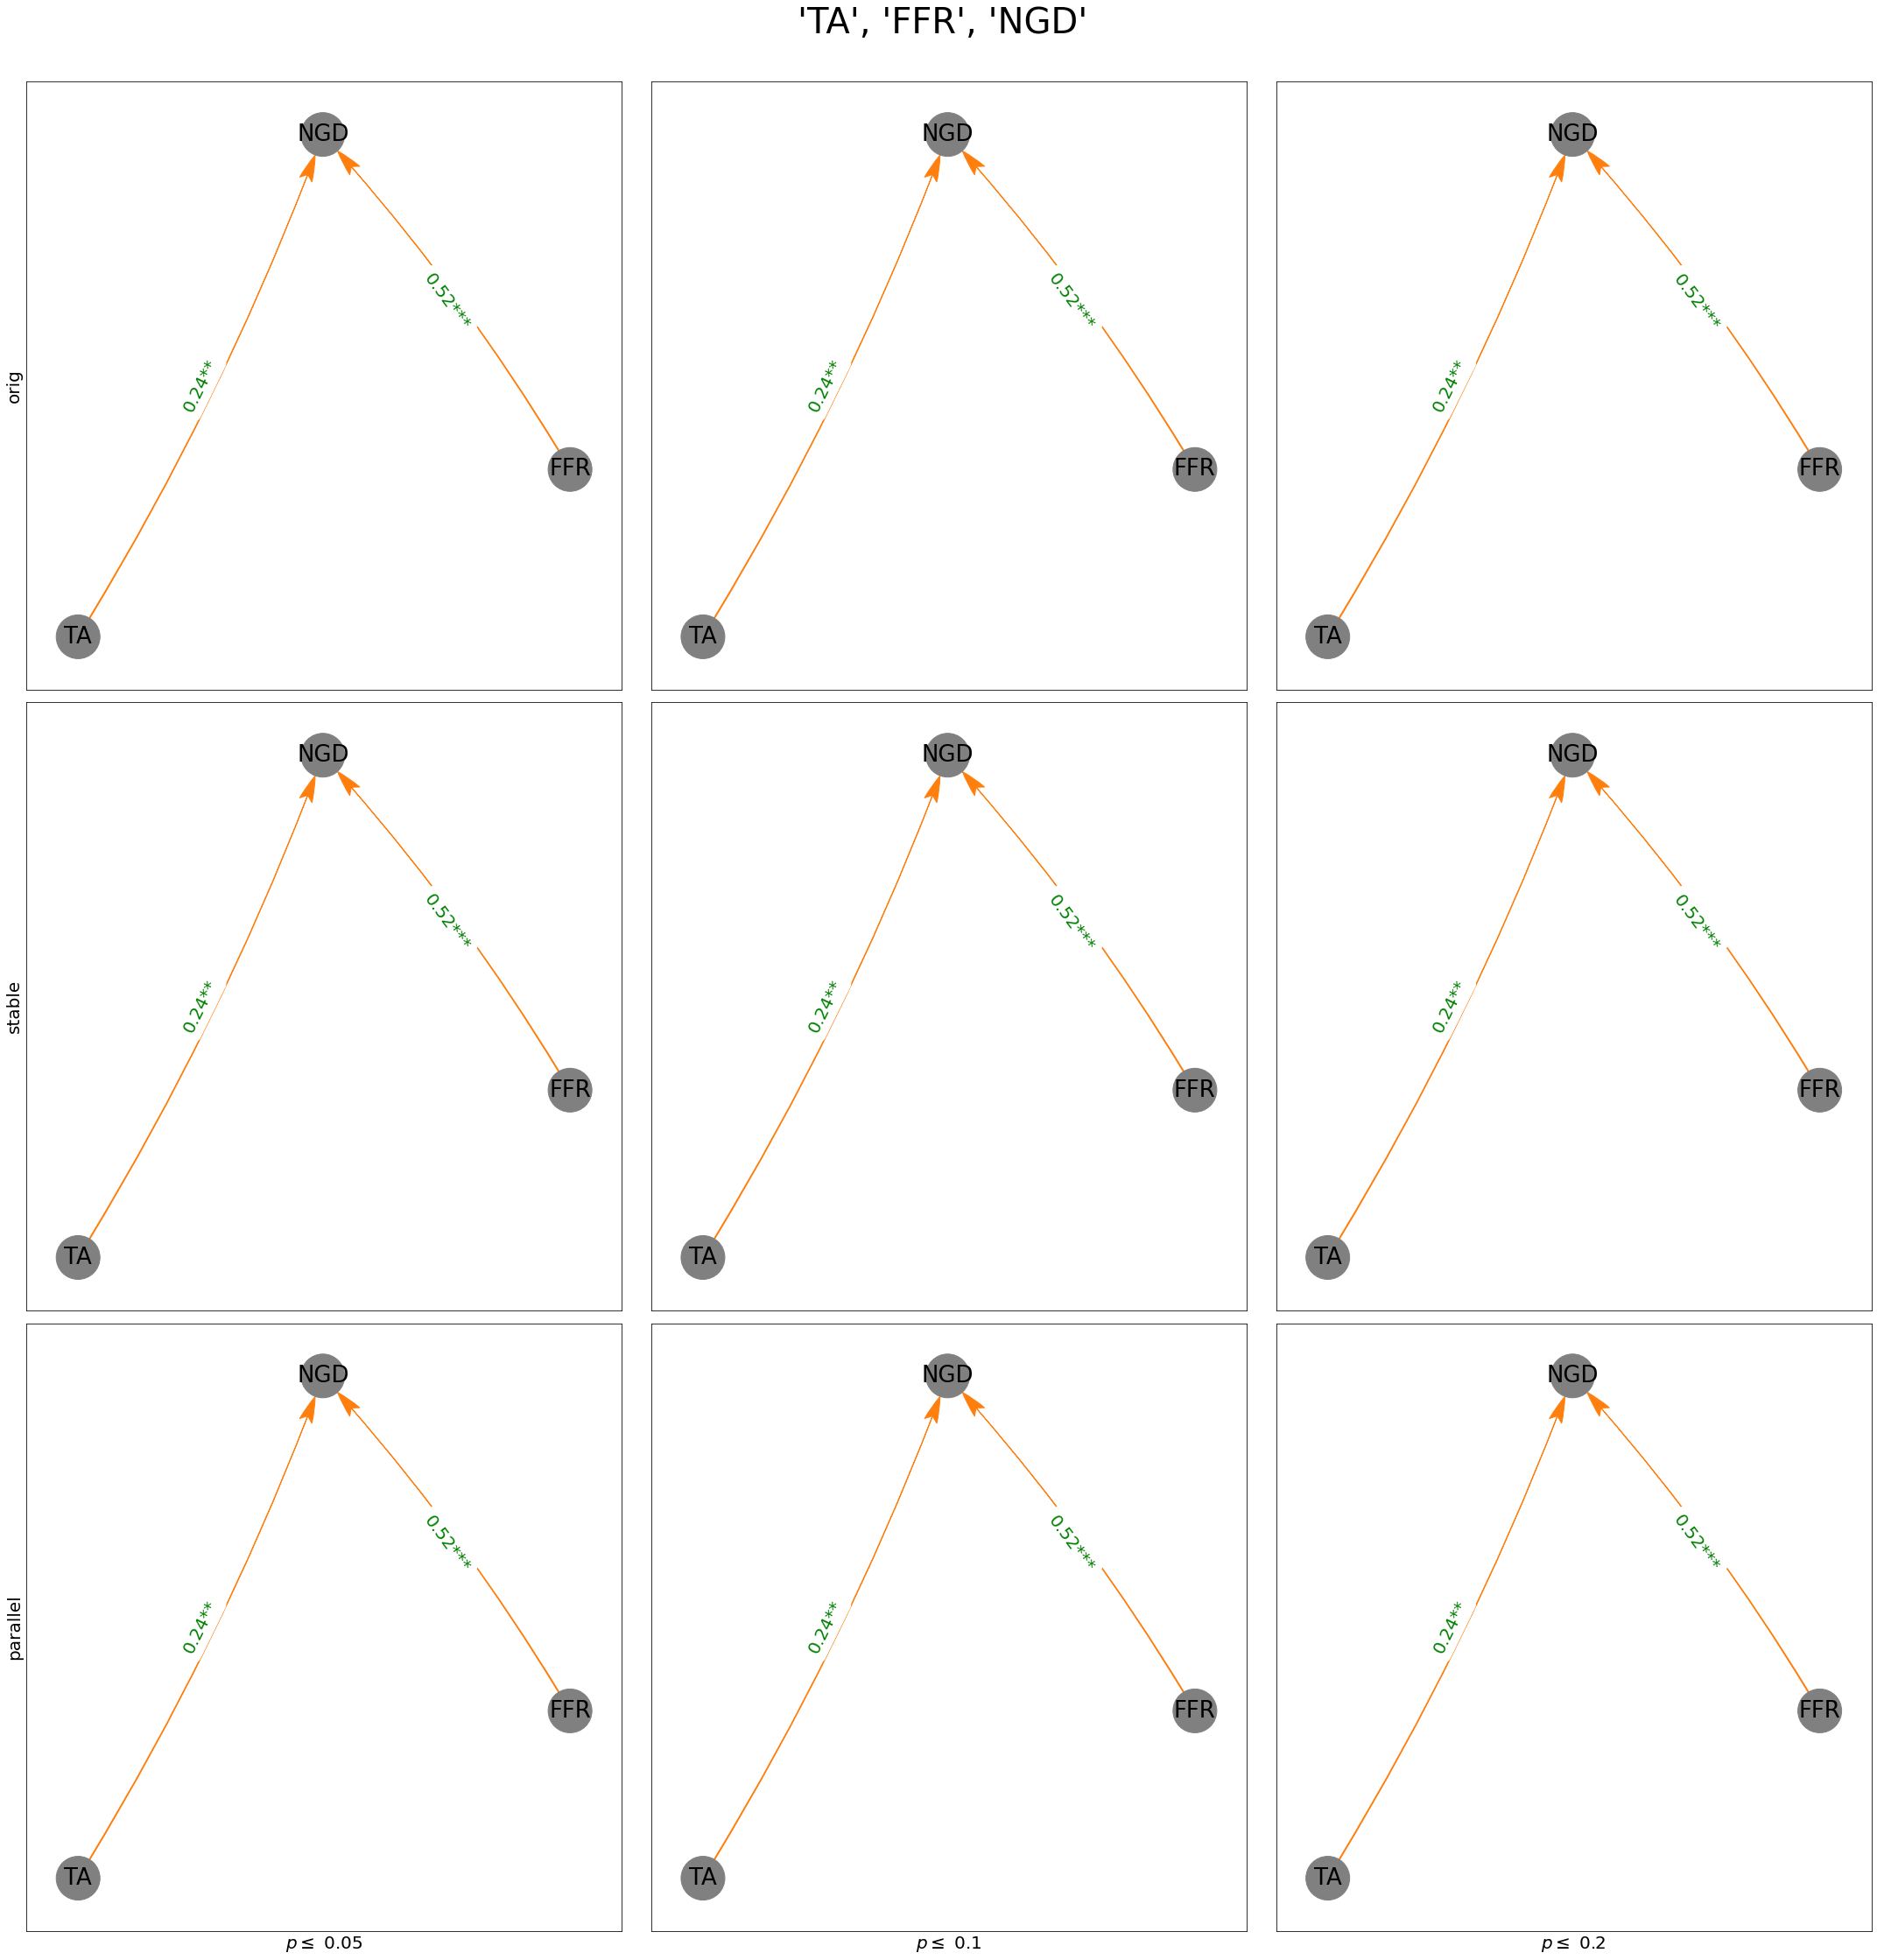

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

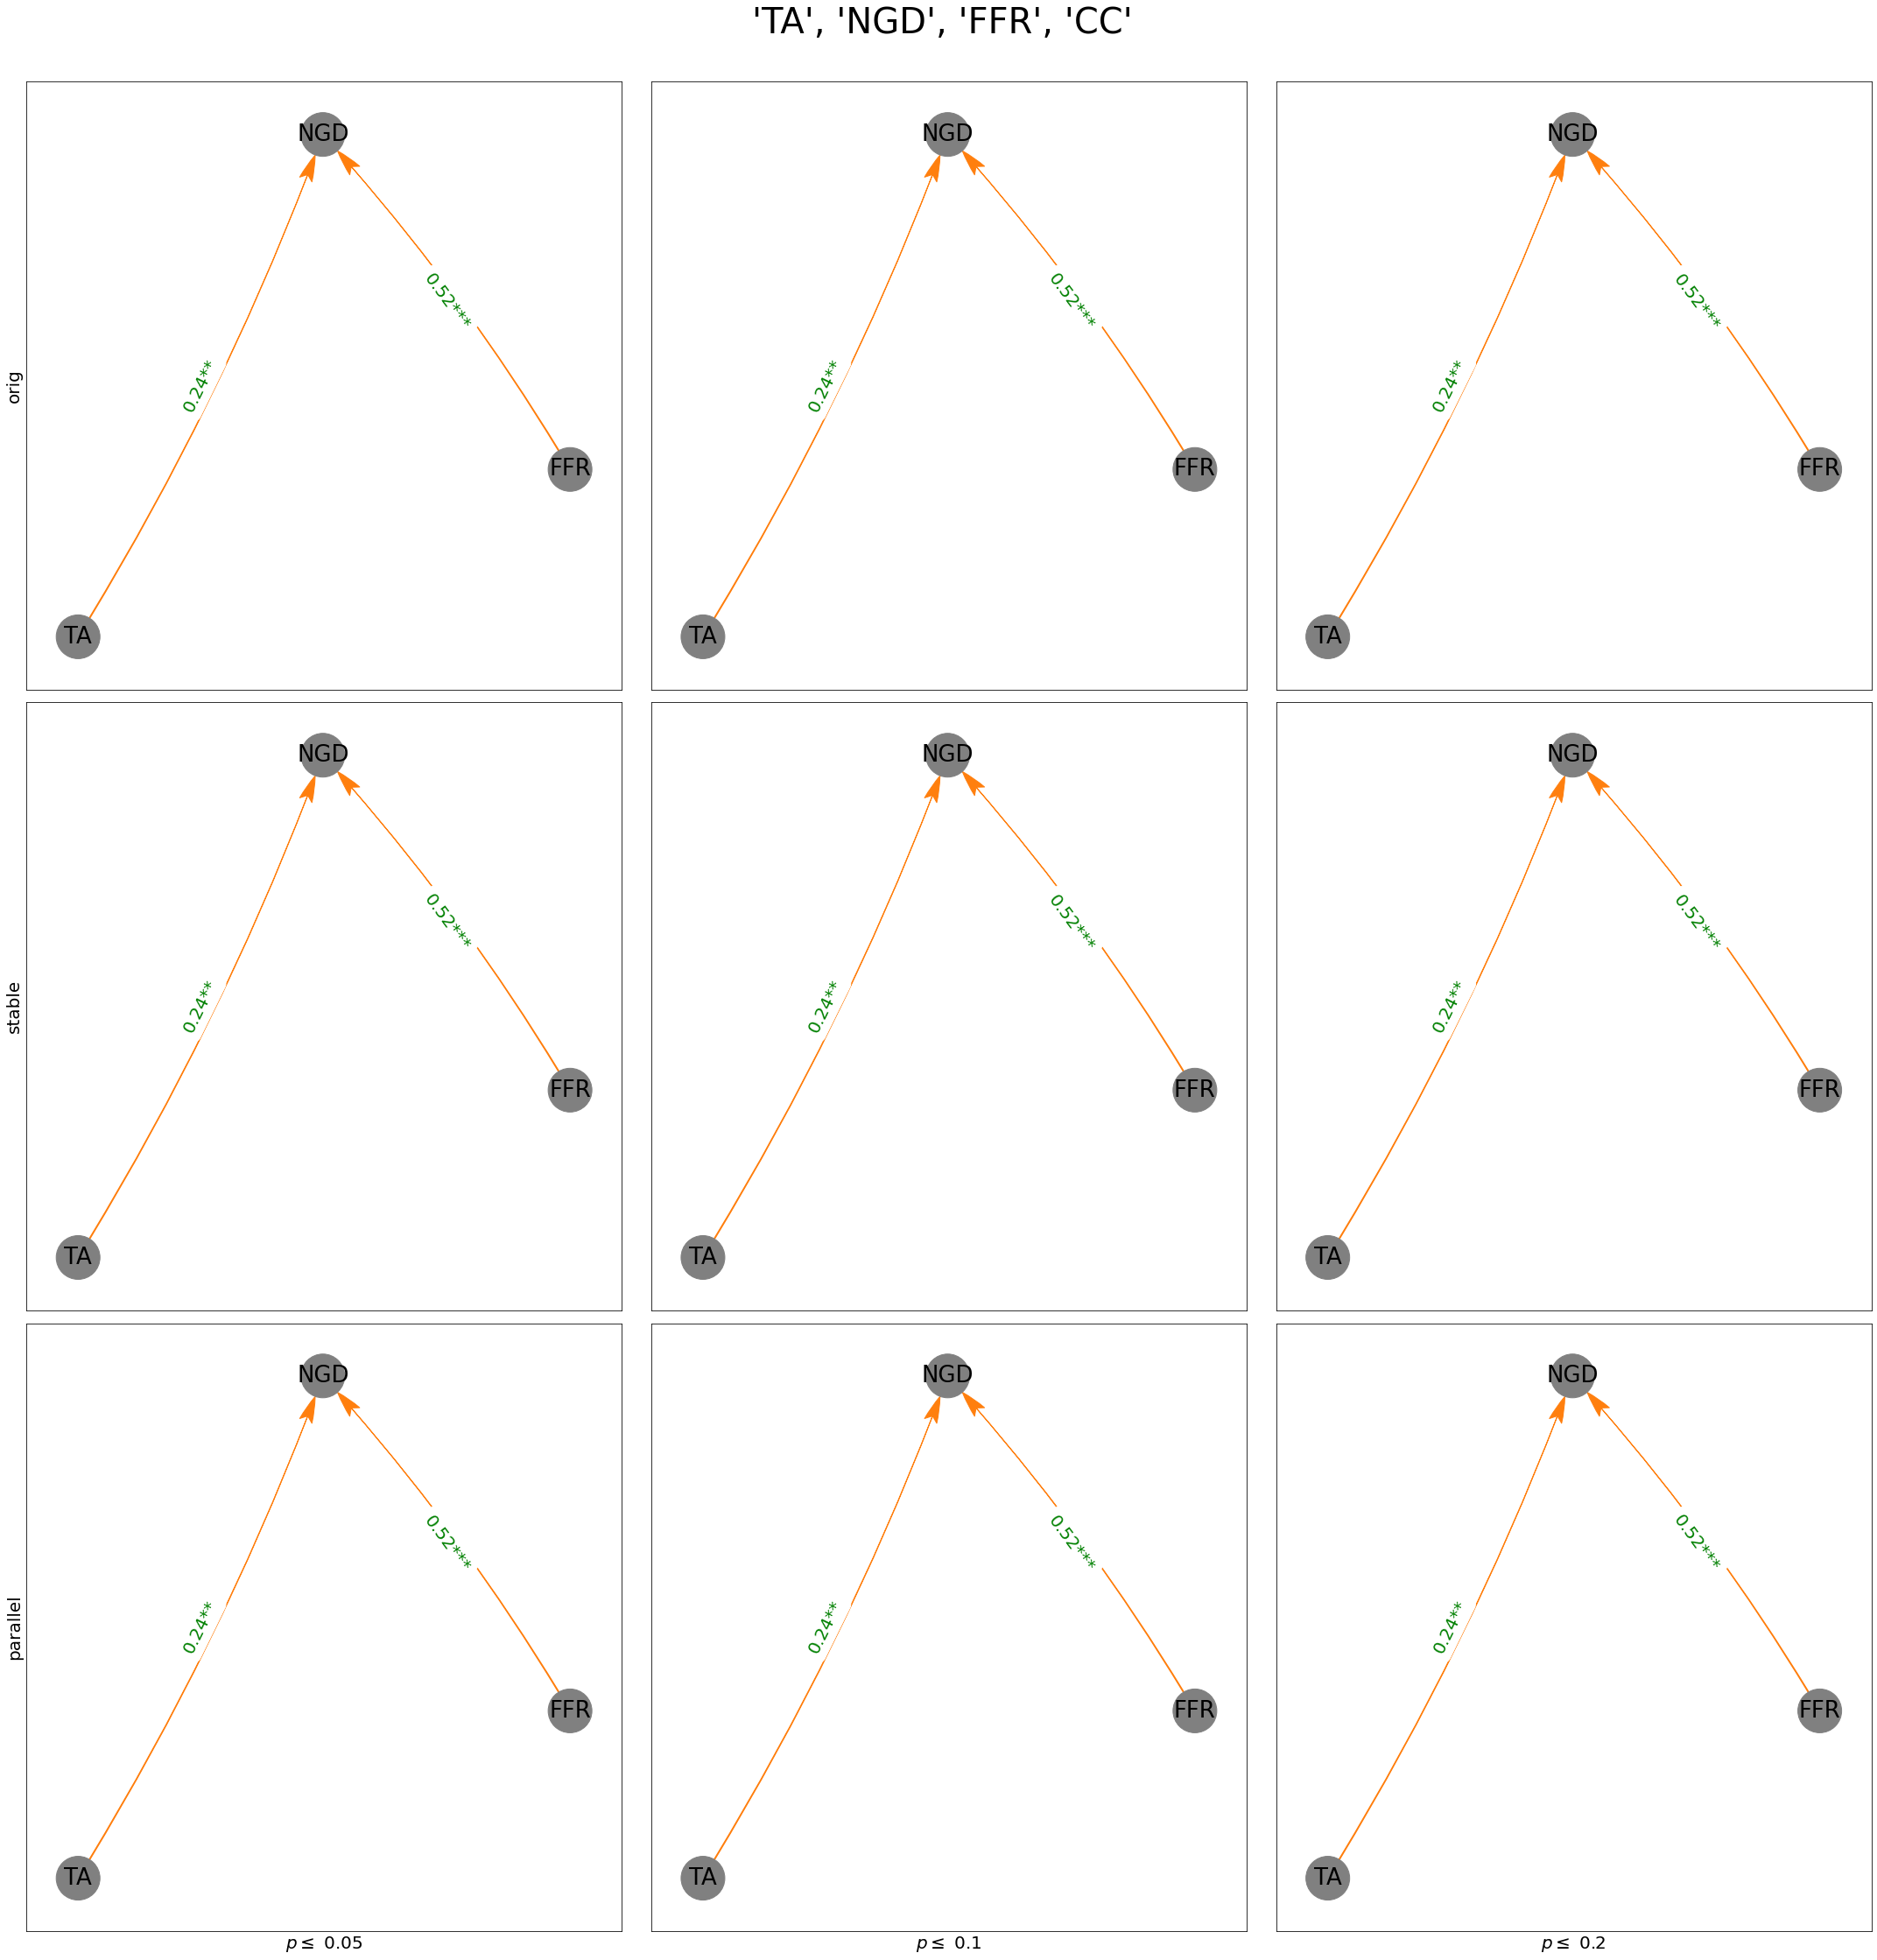

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
def graph_DAG(edges, data_reg, title = "", 
              fig = False, ax = False, 
              edge_labels = False,sig_vals = [0.05, 0.01, 0.001]):
    pcorr = data_reg.pcorr()
    graph = nx.DiGraph()
    def build_edge_labels(edges, df, sig_vals):
        edge_labels = {}
        for edge in edges:
            controls = [key for key in df.keys() if key not in edge]
            controls = list(set(controls))
            keep_controls = []
            for control in controls:
                control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
                if (control, edge[1]) in control_edges:
                    keep_controls.append(control)                
#             print(edge, keep_controls)
            pcorr = df.partial_corr(x = edge[0], y = edge[1], covar=keep_controls,
                                  method = "pearson")
            label = str(round(pcorr["r"][0],2))
            pvalue = pcorr["p-val"][0]
#             pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#             label = pcorr[edge[0]].loc[edge[1]]

            for sig_val in sig_vals:
                if pvalue < sig_val: 
                    label = label + "*"   
            
            edge_labels[edge] = label
        return edge_labels
    
    if edge_labels == False:
        edge_labels = build_edge_labels(edges, 
                                        data_reg, 
                                        sig_vals=sig_vals) 
    graph.add_edges_from(edges)
    color_map = ["grey" for g in graph]

    if fig == False and ax == False: fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    #pos = nx.spring_layout(graph)
    pos = graphviz_layout(graph)

    edge_labels2 = []
    for u, v, d in graph.edges(data=True):
        if pos[u][0] > pos[v][0]:  
            if (v,u) in edge_labels.keys():
                edge_labels2.append(((u, v,), f'{edge_labels[u,v]}\n\n\n{edge_labels[(v,u)]}'))  
        if (v,u) not in edge_labels.keys():
            edge_labels2.append(((u,v,), f'{edge_labels[(u,v)]}'))
    edge_labels = dict(edge_labels2)

    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 2500,
                     with_labels=True,  arrows=True,
                     font_color = "black",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                     connectionstyle='arc3, rad = 0.05',
                     ax = a)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20,
                                ax = a)
    

DAG_models_vars = {0:["CC", "TA", "NGDP"],
                  1:["FFR", "CC", "NGDP"],
                  2:["TA", "FFR", "NGDP"],
                  3:["TA", "NGDP", "FFR", "CC"],
                  4:["TA", "U", "FFR", "CC"],
                  5:["TA", "NGDP", "FFR", "CC","U"],}
# link_sigs = [0.05, 0.1, 0.2]
link_sigs = [0.05, .1, .2]
algorithms = ["orig", "stable", "parallel"]
for keys in DAG_models_vars.values():
    fig, ax = plt.subplots(len(algorithms), len(link_sigs), figsize = (30,30))
    max_cond_vars = len(keys) - 2
    data_reg = data[keys].dropna()
    data_reg.rename(columns = {col:firstLetterWord(col) for col in keys}, inplace = True)
    keys = data_reg.keys()
    c = PC(data_reg[keys].dropna())
    max_cond_vars = len(keys) - 2
    i,j = 0,0
    for sig in link_sigs:
        for algorithm in algorithms:
            model = c.estimate(return_type = "pdag", variant = algorithm, 
                               significance_level = sig, 
                               max_cond_vars = max_cond_vars, ci_test = "pearsonr")
            edges = model.edges()
            pcorr = data_reg.pcorr()
            weights = {}
            a = ax[i][j]
            graph_DAG(edges, data_reg, fig = fig, ax = a)
        
            if j == 0:
                a.set_ylabel(algorithm, fontsize = 20)
            if i == len(algorithms) - 1:
                a.set_xlabel("$p \leq$ "+ str(sig), fontsize = 20)
            i += 1
        j += 1
        i = 0
    plt.suptitle(str(list(keys)).replace("[","").replace("]",""), fontsize = 40, y =1.035)
    plt.show()
    plt.close()
edges

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

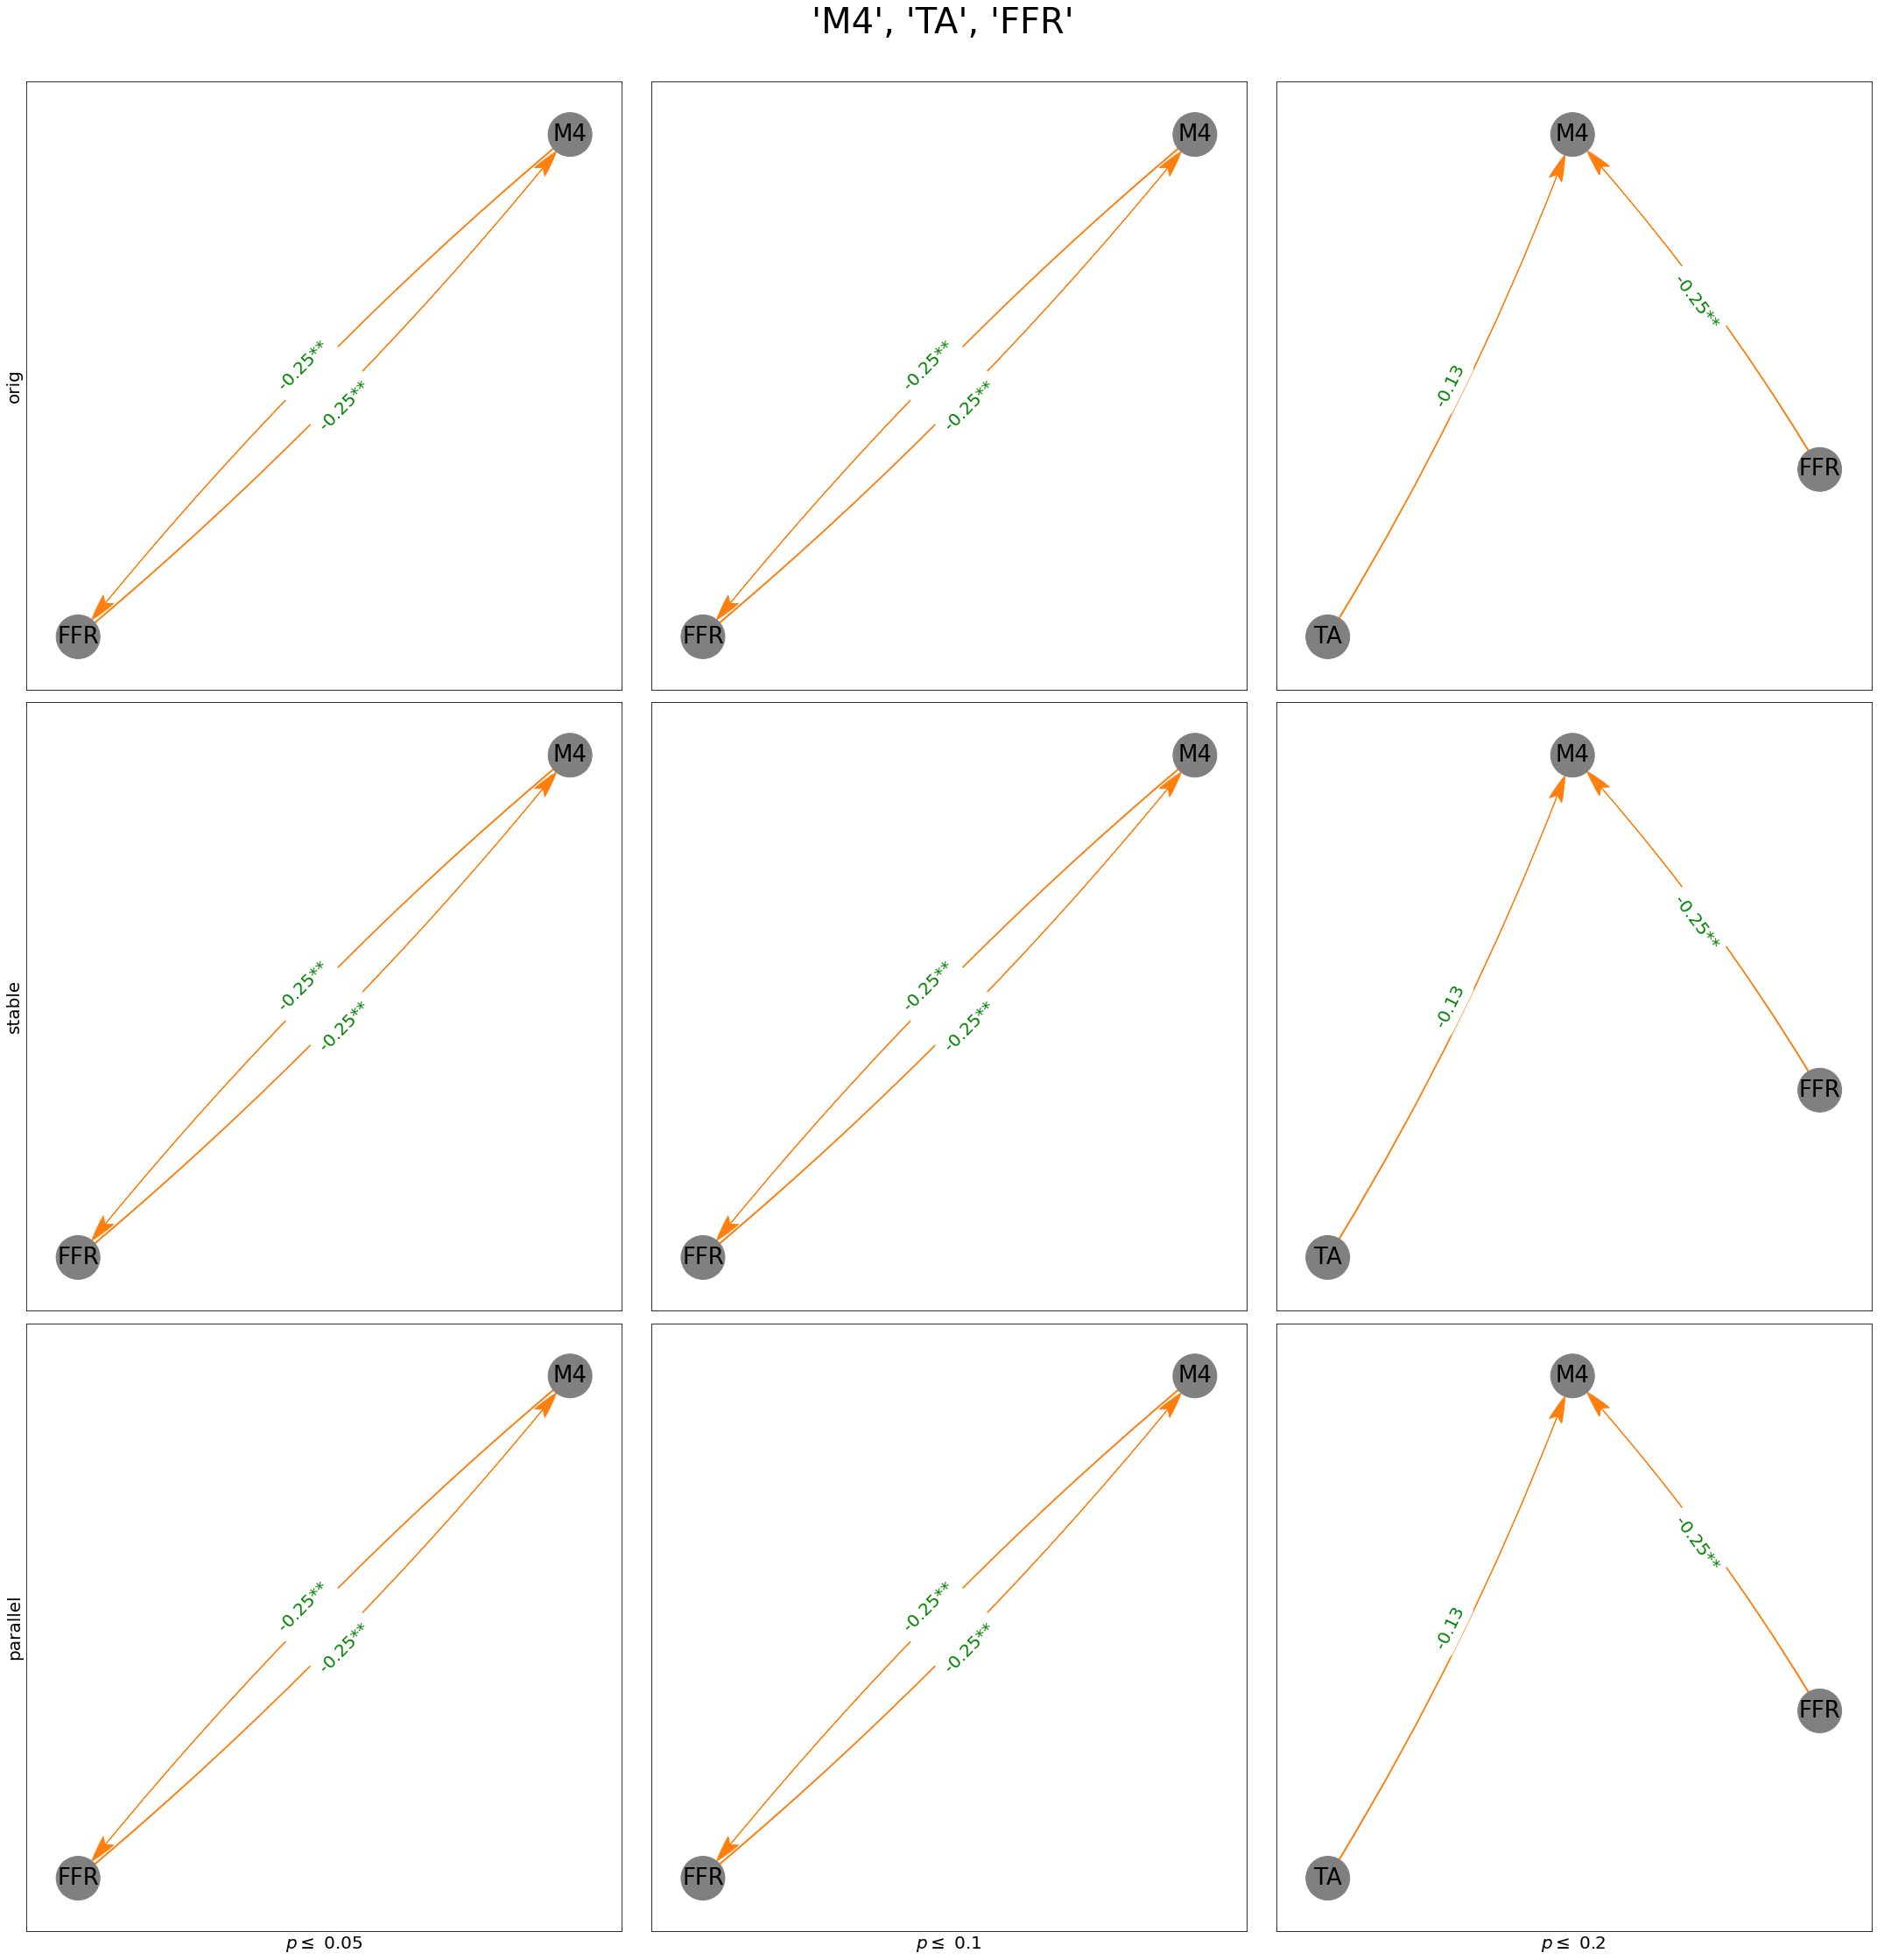

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

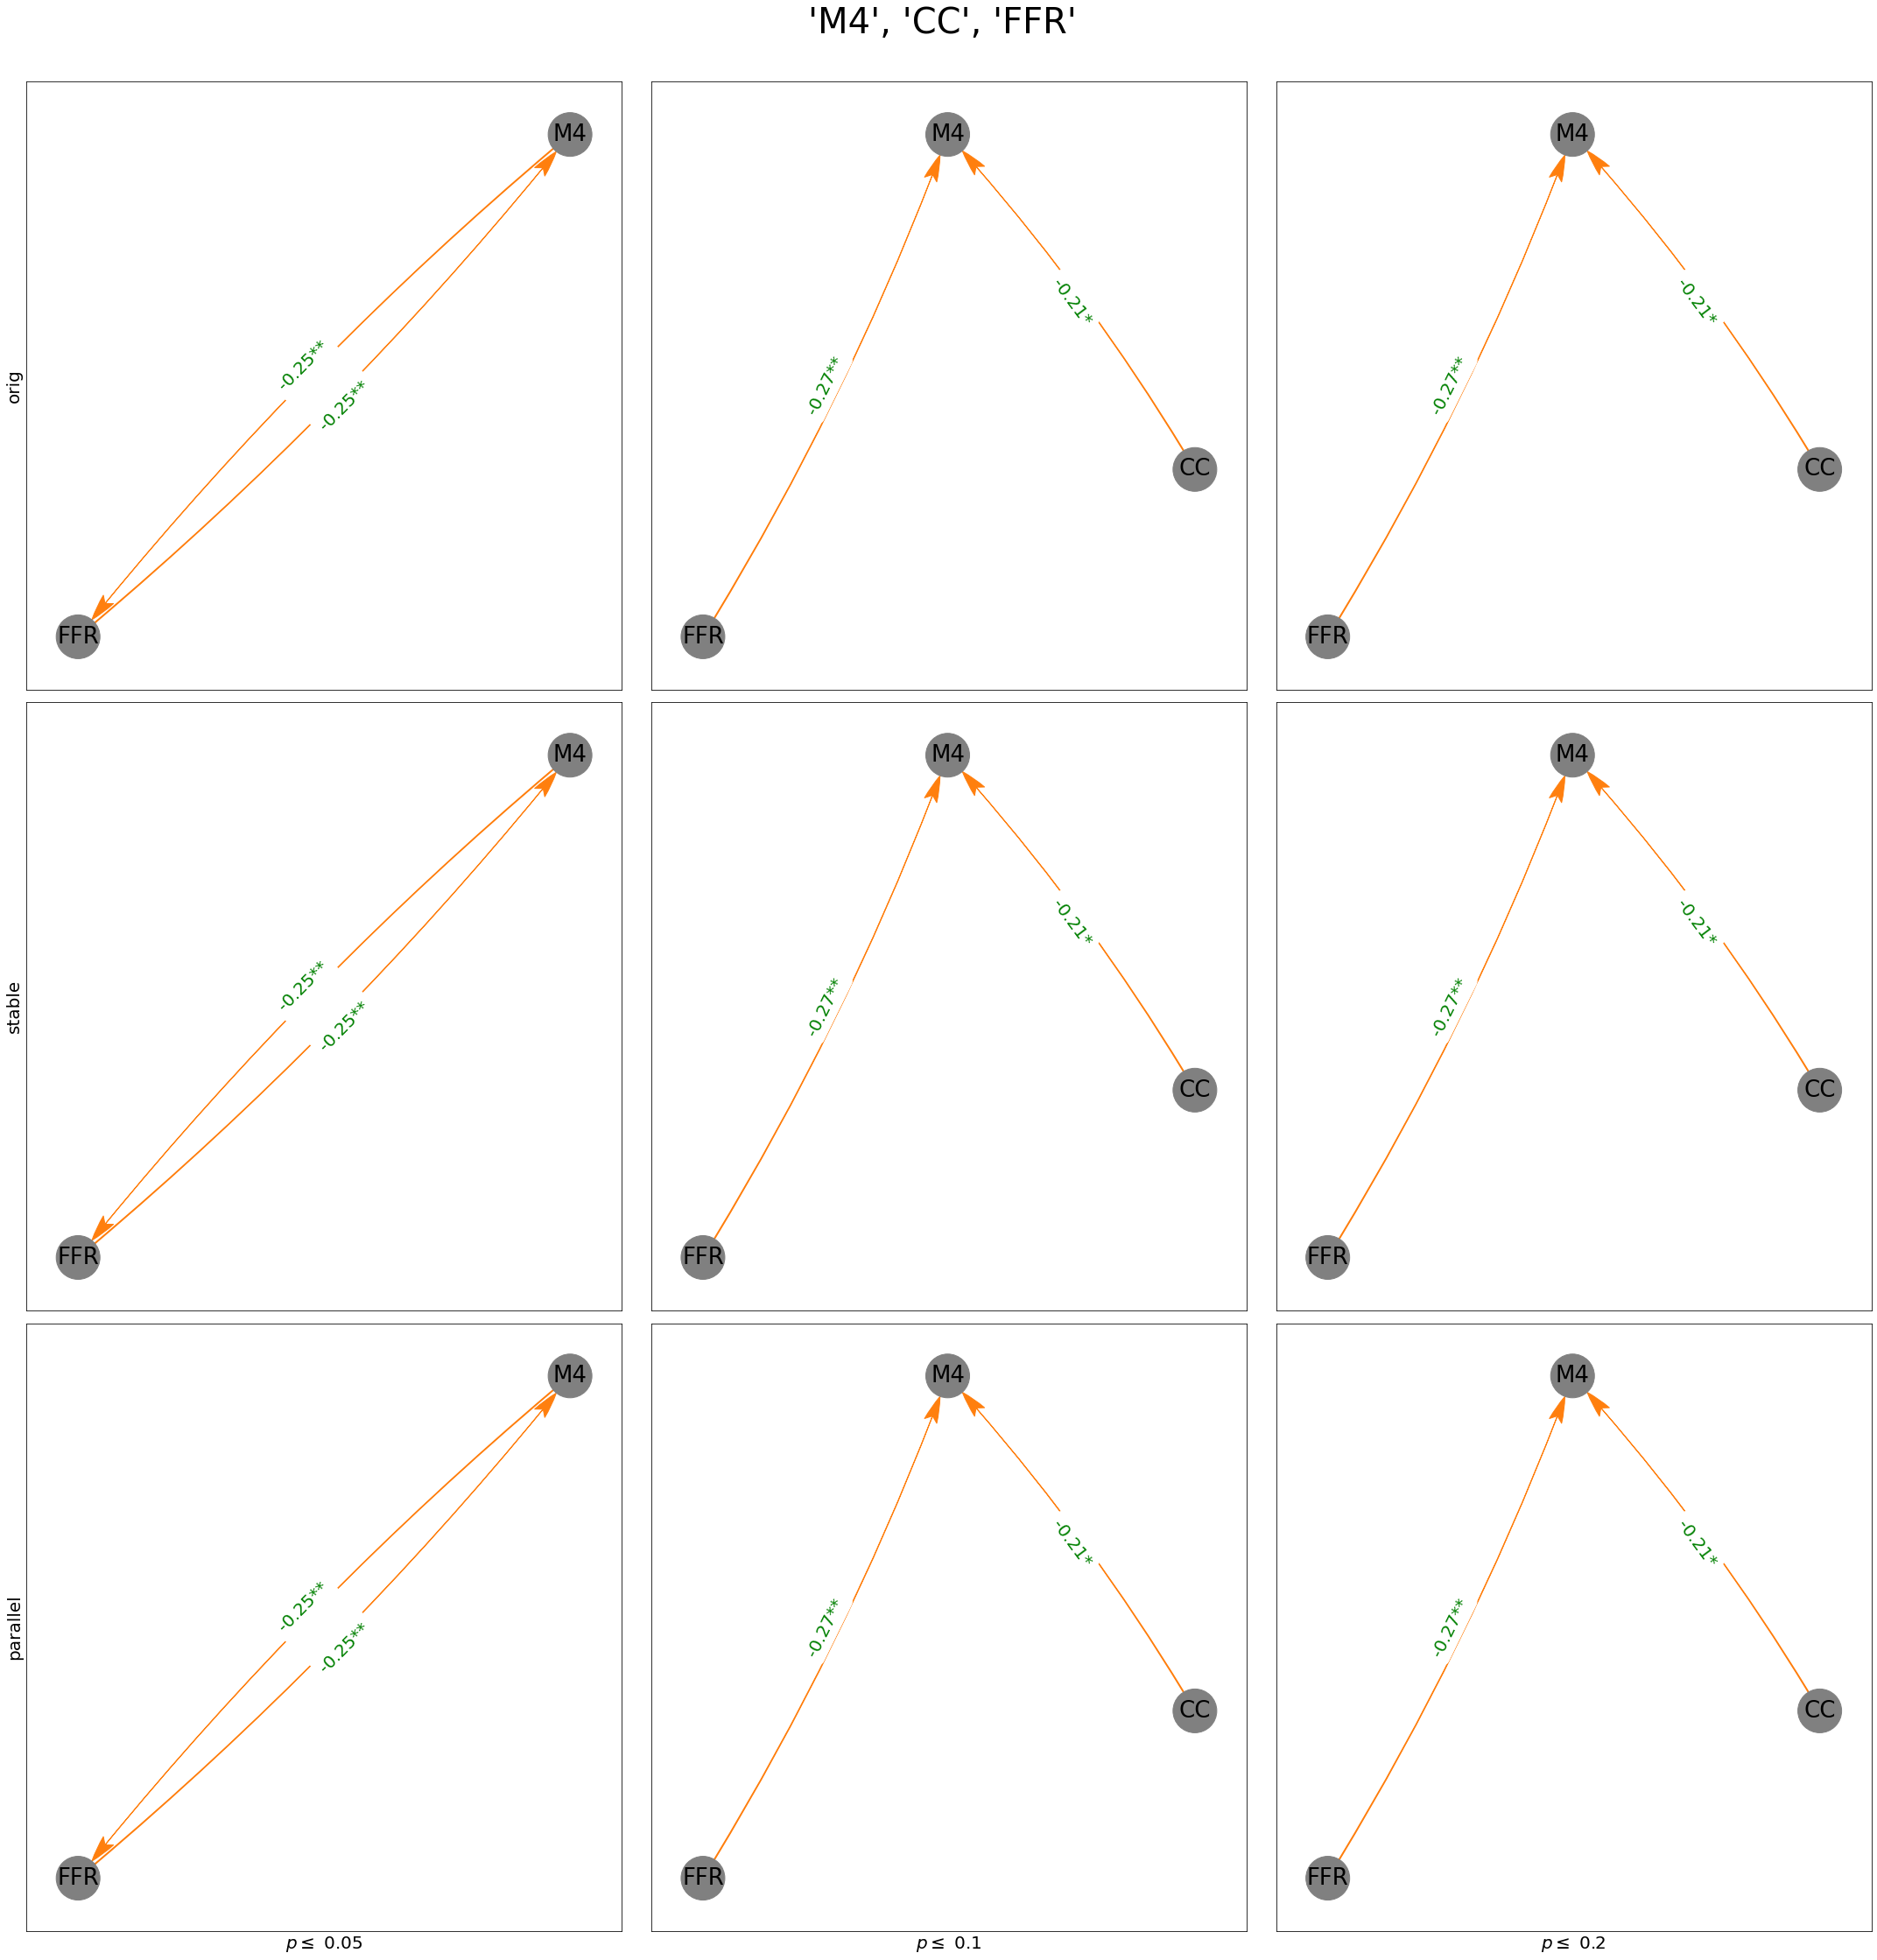

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

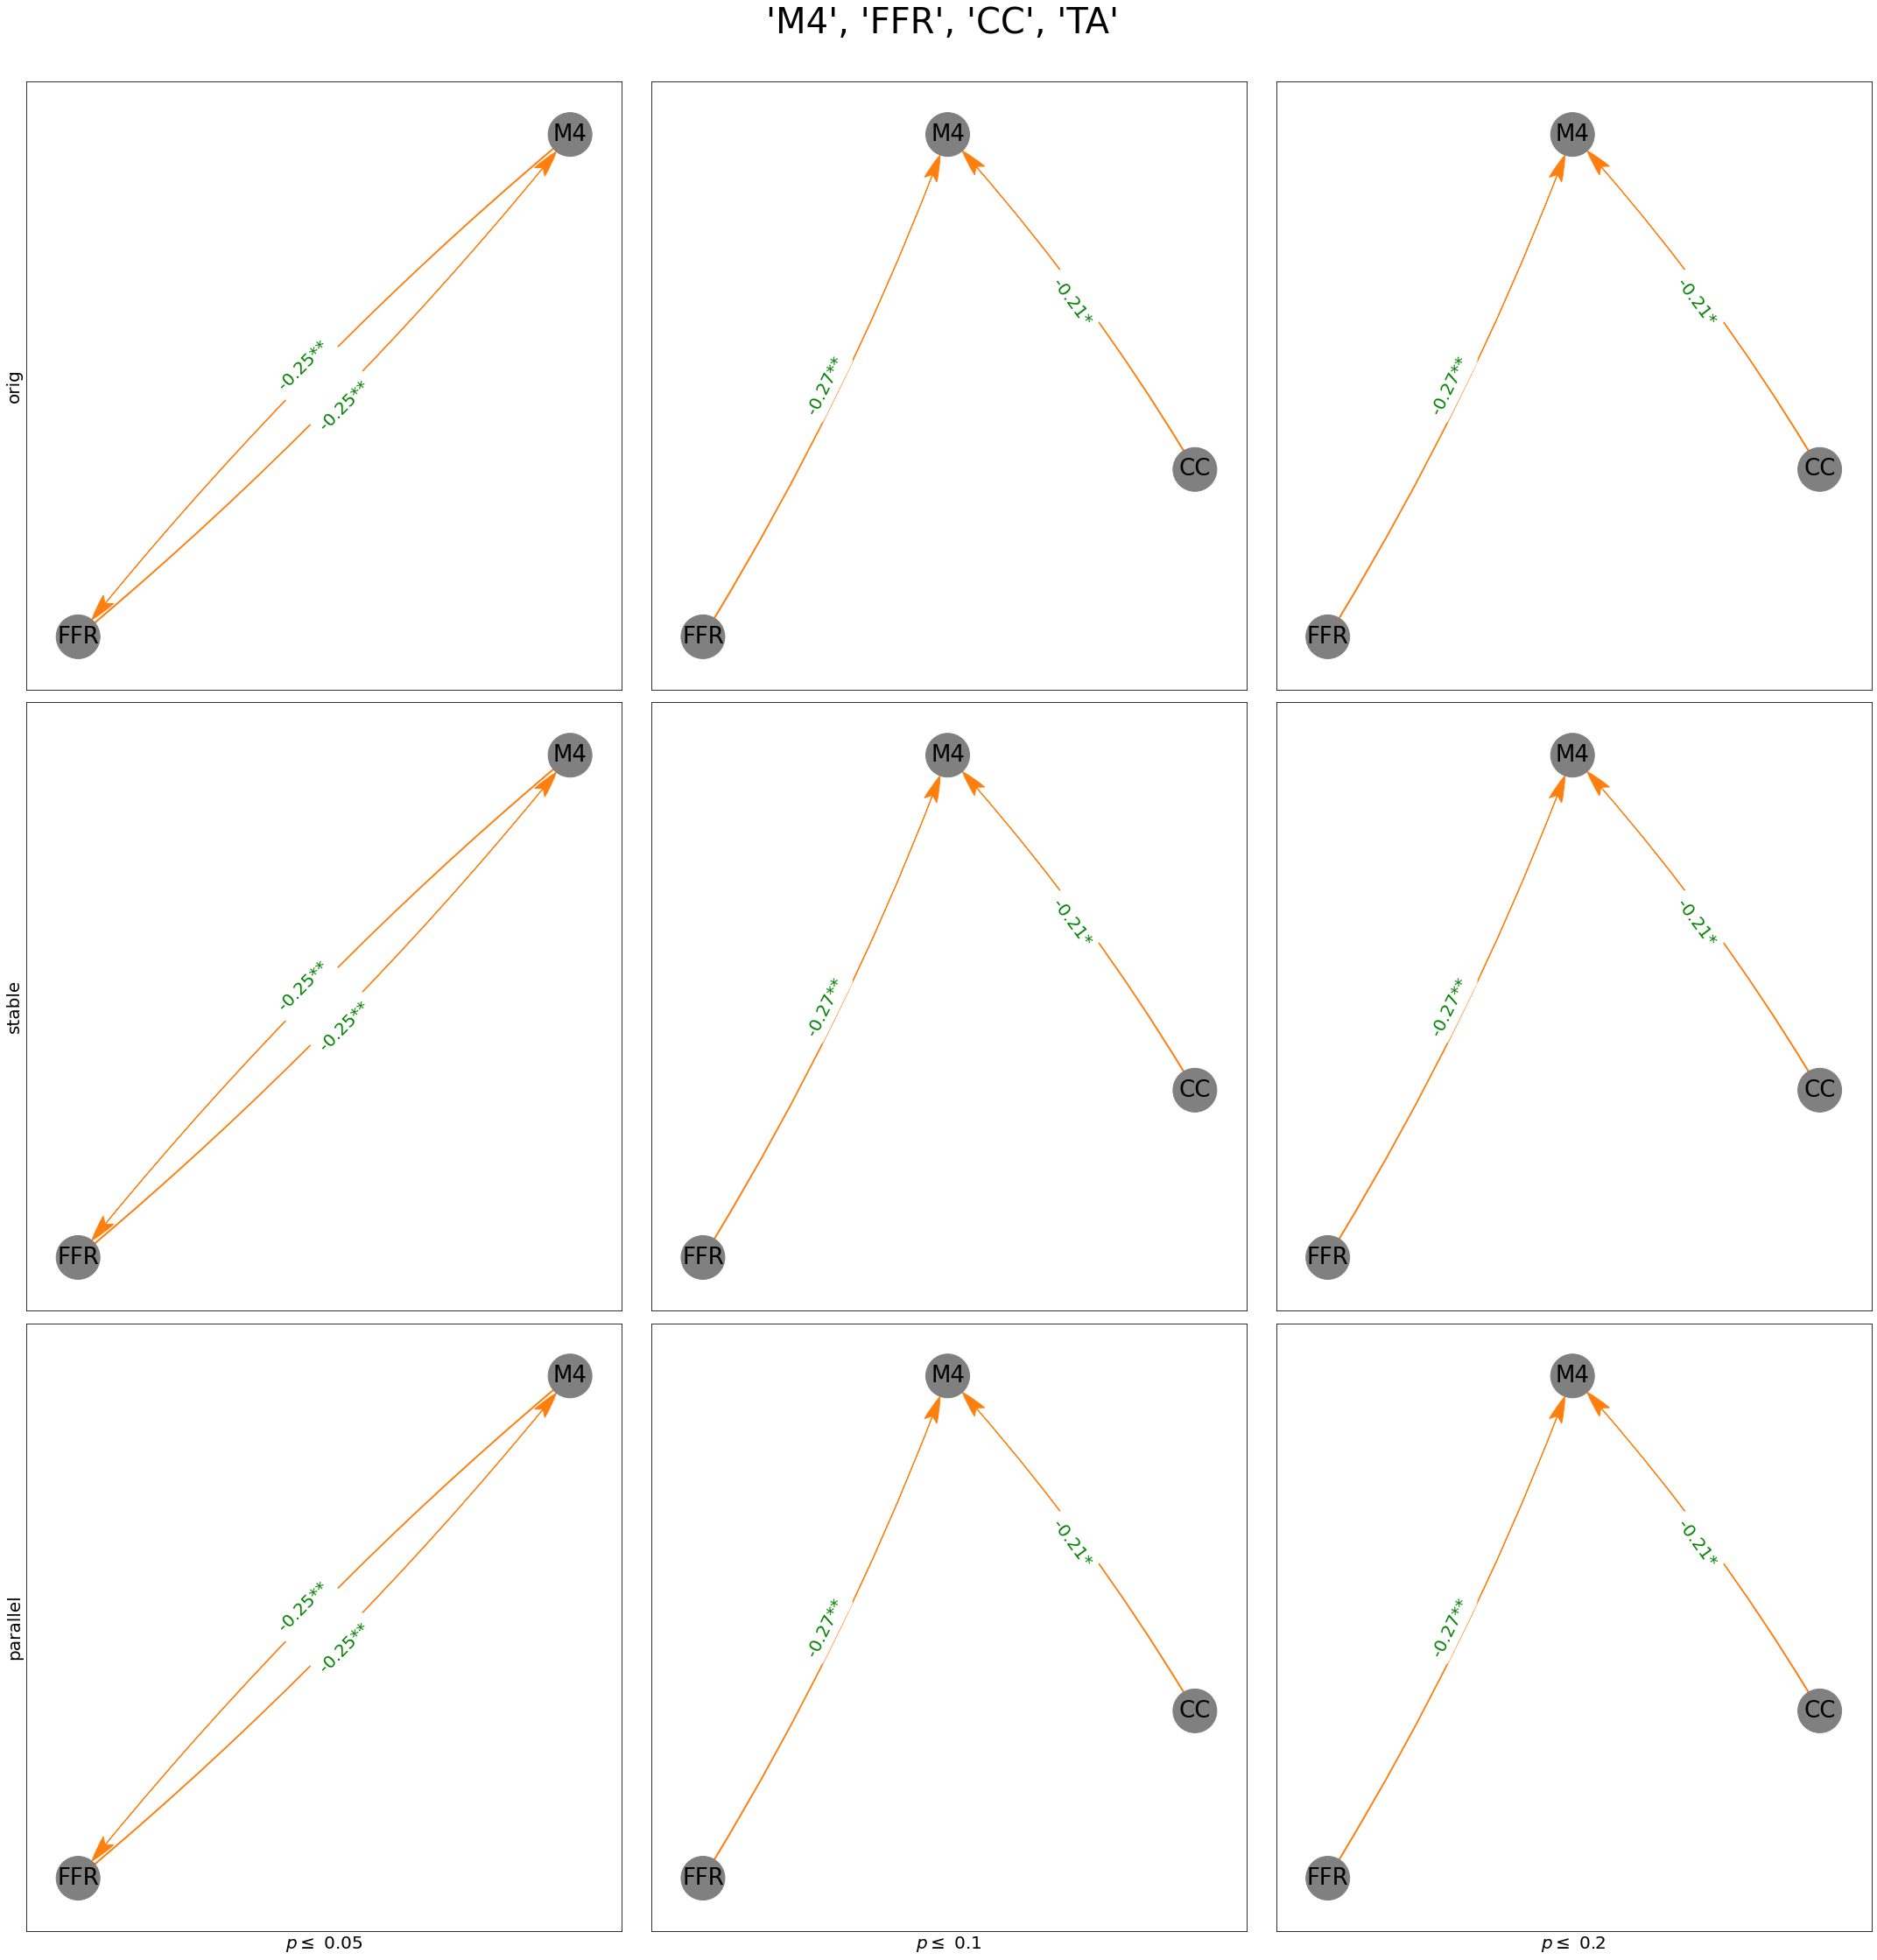

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

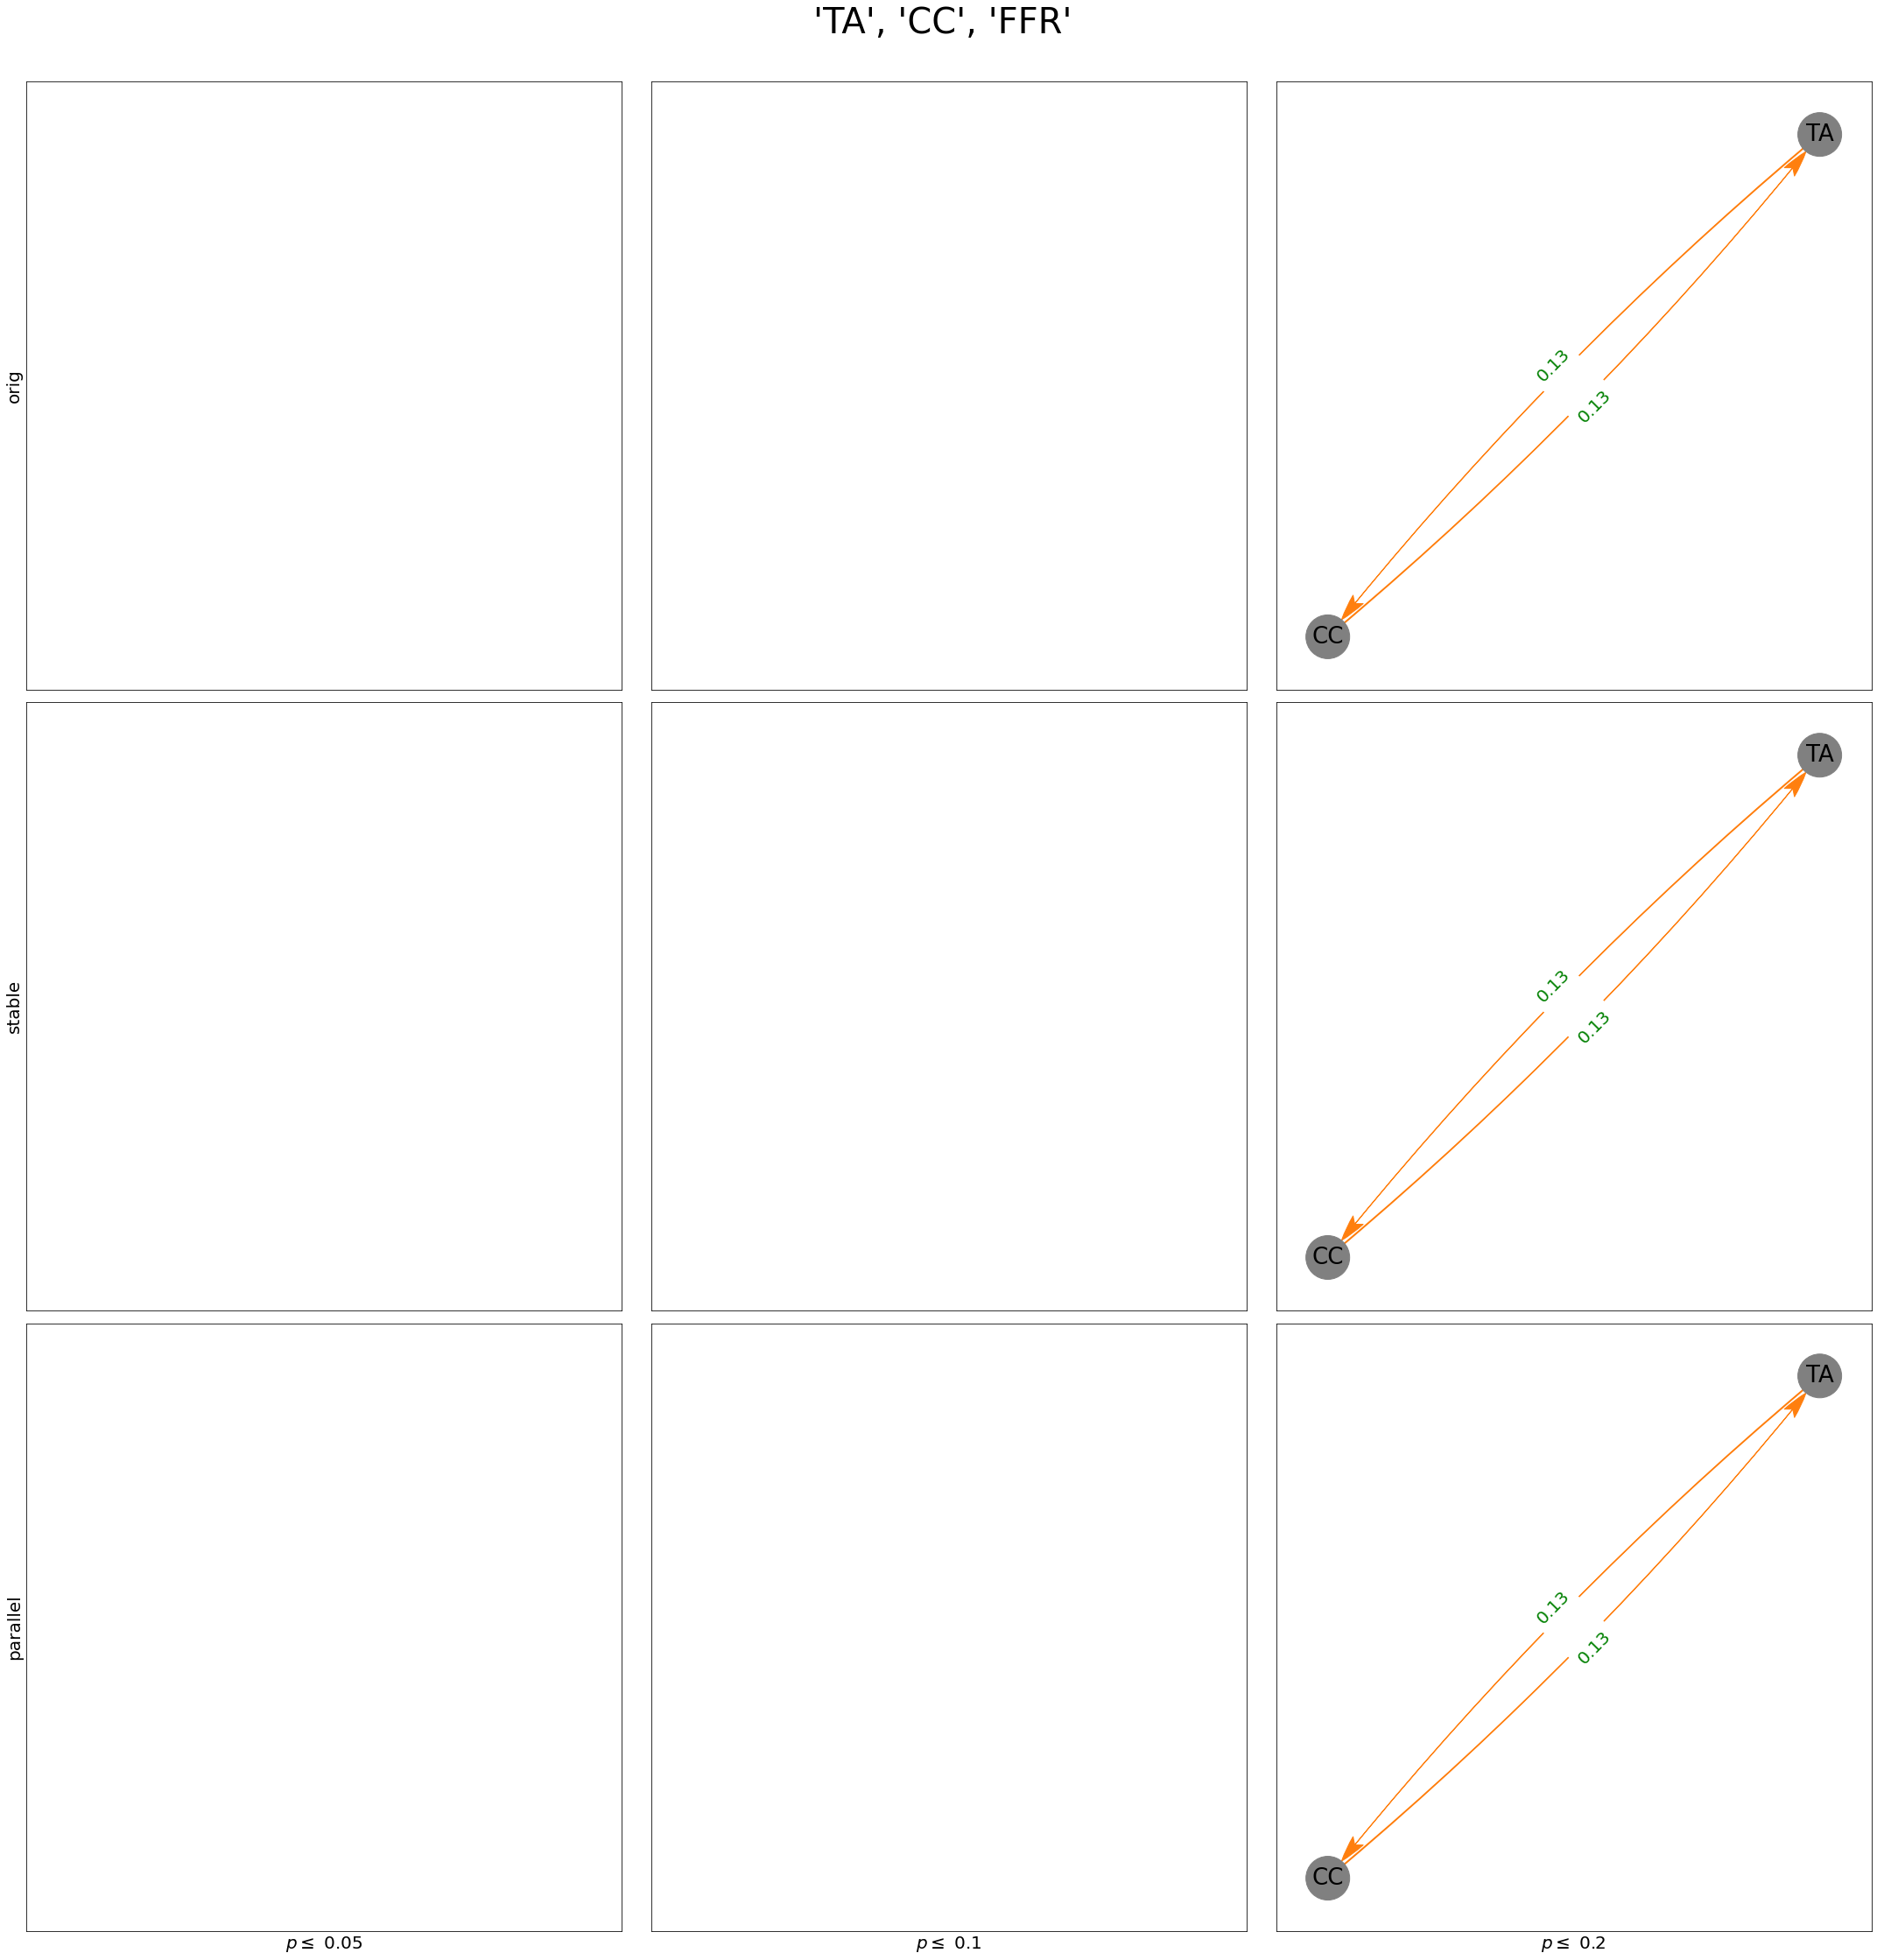

OutEdgeView([('CC', 'TA'), ('TA', 'CC')])

In [26]:
def graph_DAG(edges, data_reg, title = "", 
              fig = False, ax = False, 
              edge_labels = False,sig_vals = [0.05, 0.01, 0.001]):
    pcorr = data_reg.pcorr()
    graph = nx.DiGraph()
    def build_edge_labels(edges, df, sig_vals):
        edge_labels = {}
        for edge in edges:
            controls = [key for key in df.keys() if key not in edge]
            controls = list(set(controls))
            keep_controls = []
            for control in controls:
                control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
                if (control, edge[1]) in control_edges:
                    keep_controls.append(control)                
#             print(edge, keep_controls)
            pcorr = df.partial_corr(x = edge[0], y = edge[1], covar=keep_controls,
                                  method = "pearson")
            label = str(round(pcorr["r"][0],2))
            pvalue = pcorr["p-val"][0]
#             pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#             label = pcorr[edge[0]].loc[edge[1]]

            for sig_val in sig_vals:
                if pvalue < sig_val: 
                    label = label + "*"   
            
            edge_labels[edge] = label
        return edge_labels
    
    if edge_labels == False:
        edge_labels = build_edge_labels(edges, 
                                        data_reg, 
                                        sig_vals=sig_vals) 
    graph.add_edges_from(edges)
    color_map = ["grey" for g in graph]

    if fig == False and ax == False: fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    #pos = nx.spring_layout(graph)
    pos = graphviz_layout(graph)

    edge_labels2 = []
    for u, v, d in graph.edges(data=True):
        if pos[u][0] > pos[v][0]:  
            if (v,u) in edge_labels.keys():
                edge_labels2.append(((u, v,), f'{edge_labels[u,v]}\n\n\n{edge_labels[(v,u)]}'))  
        if (v,u) not in edge_labels.keys():
            edge_labels2.append(((u,v,), f'{edge_labels[(u,v)]}'))
    edge_labels = dict(edge_labels2)

    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 2500,
                     with_labels=True,  arrows=True,
                     font_color = "black",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                     connectionstyle='arc3, rad = 0.05',
                     ax = a)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20,
                                ax = a)
    

DAG_models_vars = {0:["M4", "TA", "FFR"],
                  1:["M4", "CC", "FFR"],
                  2:["M4", "FFR", "CC", "TA"],
                  3:["TA", "CC", "FFR"]}
# link_sigs = [0.05, 0.1, 0.2]
link_sigs = [0.05, .1, .2]
algorithms = ["orig", "stable", "parallel"]
for keys in DAG_models_vars.values():
    fig, ax = plt.subplots(len(algorithms), len(link_sigs), figsize = (30,30))
    max_cond_vars = len(keys) - 2
    data_reg = data[keys].dropna()
    data_reg.rename(columns = {col:firstLetterWord(col) for col in keys}, inplace = True)
    keys = data_reg.keys()
    c = PC(data_reg[keys].dropna())
    max_cond_vars = len(keys) - 2
    i,j = 0,0
    for sig in link_sigs:
        for algorithm in algorithms:
            model = c.estimate(return_type = "pdag", variant = algorithm, 
                               significance_level = sig, 
                               max_cond_vars = max_cond_vars, ci_test = "pearsonr")
            edges = model.edges()
            pcorr = data_reg.pcorr()
            weights = {}
            a = ax[i][j]
            graph_DAG(edges, data_reg, fig = fig, ax = a)
        
            if j == 0:
                a.set_ylabel(algorithm, fontsize = 20)
            if i == len(algorithms) - 1:
                a.set_xlabel("$p \leq$ "+ str(sig), fontsize = 20)
            i += 1
        j += 1
        i = 0
    plt.suptitle(str(list(keys)).replace("[","").replace("]",""), fontsize = 40, y =1.035)
    plt.show()
    plt.close()
edges